In [54]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [55]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [56]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [57]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [58]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [59]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [60]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [61]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [62]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [63]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [64]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [65]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Relying on 'stored_game_boxes' currently loaded into memory
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 322450012.
[14/5670] Updating 5FR Margin for game_id 322450025...
[14/5670] Updated 5FR Margin for game_id 322450025.
[15/5670] Updating 5FR Margin for game_id 322450030...
[15/5670] Updated 5FR Margin for game_id 322

[87/5670] Updated 5FR Margin for game_id 322570058.
[88/5670] Updating 5FR Margin for game_id 322582439...
[88/5670] Updated 5FR Margin for game_id 322582439.
[89/5670] Updating 5FR Margin for game_id 322590002...
[89/5670] Updated 5FR Margin for game_id 322590002.
[90/5670] Updating 5FR Margin for game_id 322590008...
[90/5670] Updated 5FR Margin for game_id 322590008.
[91/5670] Updating 5FR Margin for game_id 322590023...
[91/5670] Updated 5FR Margin for game_id 322590023.
[92/5670] Updating 5FR Margin for game_id 322590024...
[92/5670] Updated 5FR Margin for game_id 322590024.
[93/5670] Updating 5FR Margin for game_id 322590026...
[93/5670] Updated 5FR Margin for game_id 322590026.
[94/5670] Updating 5FR Margin for game_id 322590052...
[94/5670] Updated 5FR Margin for game_id 322590052.
[95/5670] Updating 5FR Margin for game_id 322590059...
[95/5670] Updated 5FR Margin for game_id 322590059.
[96/5670] Updating 5FR Margin for game_id 322590061...
[96/5670] Updated 5FR Margin for game

[165/5670] Updated 5FR Margin for game_id 322660277.
[166/5670] Updating 5FR Margin for game_id 322660333...
[166/5670] Updated 5FR Margin for game_id 322660333.
[167/5670] Updating 5FR Margin for game_id 322660344...
[167/5670] Updated 5FR Margin for game_id 322660344.
[168/5670] Updating 5FR Margin for game_id 322660356...
[168/5670] Updated 5FR Margin for game_id 322660356.
[169/5670] Updating 5FR Margin for game_id 322662050...
[169/5670] Updated 5FR Margin for game_id 322662050.
[170/5670] Updating 5FR Margin for game_id 322662229...
[170/5670] Updated 5FR Margin for game_id 322662229.
[171/5670] Updating 5FR Margin for game_id 322662294...
[171/5670] Updated 5FR Margin for game_id 322662294.
[172/5670] Updating 5FR Margin for game_id 322662439...
[172/5670] Updated 5FR Margin for game_id 322662439.
[173/5670] Updating 5FR Margin for game_id 322662459...
[173/5670] Updated 5FR Margin for game_id 322662459.
[174/5670] Updating 5FR Margin for game_id 322662483...
[174/5670] Updated 

[247/5670] Updated 5FR Margin for game_id 322800164.
[248/5670] Updating 5FR Margin for game_id 322800167...
[248/5670] Updated 5FR Margin for game_id 322800167.
[249/5670] Updating 5FR Margin for game_id 322800194...
[249/5670] Updated 5FR Margin for game_id 322800194.
[250/5670] Updating 5FR Margin for game_id 322800195...
[250/5670] Updated 5FR Margin for game_id 322800195.
[251/5670] Updating 5FR Margin for game_id 322800204...
[251/5670] Updated 5FR Margin for game_id 322800204.
[252/5670] Updating 5FR Margin for game_id 322800213...
[252/5670] Updated 5FR Margin for game_id 322800213.
[253/5670] Updating 5FR Margin for game_id 322800218...
[253/5670] Updated 5FR Margin for game_id 322800218.
[254/5670] Updating 5FR Margin for game_id 322800228...
[254/5670] Updated 5FR Margin for game_id 322800228.
[255/5670] Updating 5FR Margin for game_id 322800235...
[255/5670] Updated 5FR Margin for game_id 322800235.
[256/5670] Updating 5FR Margin for game_id 322800248...
[256/5670] Updated 

[327/5670] Updated 5FR Margin for game_id 322872459.
[328/5670] Updating 5FR Margin for game_id 322872509...
[328/5670] Updated 5FR Margin for game_id 322872509.
[329/5670] Updating 5FR Margin for game_id 322872641...
[329/5670] Updated 5FR Margin for game_id 322872641.
[330/5670] Updating 5FR Margin for game_id 322872751...
[330/5670] Updated 5FR Margin for game_id 322872751.
[331/5670] Updating 5FR Margin for game_id 322900249...
[331/5670] Updated 5FR Margin for game_id 322900249.
[332/5670] Updating 5FR Margin for game_id 322920009...
[332/5670] Updated 5FR Margin for game_id 322920009.
[333/5670] Updating 5FR Margin for game_id 322922567...
[333/5670] Updated 5FR Margin for game_id 322922567.
[334/5670] Updating 5FR Margin for game_id 322930183...
[334/5670] Updated 5FR Margin for game_id 322930183.
[335/5670] Updating 5FR Margin for game_id 322940005...
[335/5670] Updated 5FR Margin for game_id 322940005.
[336/5670] Updating 5FR Margin for game_id 322940006...
[336/5670] Updated 

[406/5670] Updated 5FR Margin for game_id 323010142.
[407/5670] Updating 5FR Margin for game_id 323010151...
[407/5670] Updated 5FR Margin for game_id 323010151.
[408/5670] Updating 5FR Margin for game_id 323010153...
[408/5670] Updated 5FR Margin for game_id 323010153.
[409/5670] Updating 5FR Margin for game_id 323010158...
[409/5670] Updated 5FR Margin for game_id 323010158.
[410/5670] Updating 5FR Margin for game_id 323010164...
[410/5670] Updated 5FR Margin for game_id 323010164.
[411/5670] Updating 5FR Margin for game_id 323010166...
[411/5670] Updated 5FR Margin for game_id 323010166.
[412/5670] Updating 5FR Margin for game_id 323010167...
[412/5670] Updated 5FR Margin for game_id 323010167.
[413/5670] Updating 5FR Margin for game_id 323010189...
[413/5670] Updated 5FR Margin for game_id 323010189.
[414/5670] Updating 5FR Margin for game_id 323010193...
[414/5670] Updated 5FR Margin for game_id 323010193.
[415/5670] Updating 5FR Margin for game_id 323010197...
[415/5670] Updated 

[492/5670] Updated 5FR Margin for game_id 323082459.
[493/5670] Updating 5FR Margin for game_id 323082509...
[493/5670] Updated 5FR Margin for game_id 323082509.
[494/5670] Updating 5FR Margin for game_id 323082572...
[494/5670] Updated 5FR Margin for game_id 323082572.
[495/5670] Updating 5FR Margin for game_id 323082633...
[495/5670] Updated 5FR Margin for game_id 323082633.
[496/5670] Updating 5FR Margin for game_id 323082641...
[496/5670] Updated 5FR Margin for game_id 323082641.
[497/5670] Updating 5FR Margin for game_id 323082655...
[497/5670] Updated 5FR Margin for game_id 323082655.
[498/5670] Updating 5FR Margin for game_id 323082751...
[498/5670] Updated 5FR Margin for game_id 323082751.
[499/5670] Updating 5FR Margin for game_id 323112649...
[499/5670] Updated 5FR Margin for game_id 323112649.
[500/5670] Updating 5FR Margin for game_id 323120195...
[500/5670] Updated 5FR Margin for game_id 323120195.
[501/5670] Updating 5FR Margin for game_id 323130259...
[501/5670] Updated 

[572/5670] Updated 5FR Margin for game_id 323220130.
[573/5670] Updating 5FR Margin for game_id 323220142...
[573/5670] Updated 5FR Margin for game_id 323220142.
[574/5670] Updating 5FR Margin for game_id 323220158...
[574/5670] Updated 5FR Margin for game_id 323220158.
[575/5670] Updating 5FR Margin for game_id 323220167...
[575/5670] Updated 5FR Margin for game_id 323220167.
[576/5670] Updating 5FR Margin for game_id 323220189...
[576/5670] Updated 5FR Margin for game_id 323220189.
[577/5670] Updating 5FR Margin for game_id 323220197...
[577/5670] Updated 5FR Margin for game_id 323220197.
[578/5670] Updating 5FR Margin for game_id 323220202...
[578/5670] Updated 5FR Margin for game_id 323220202.
[579/5670] Updating 5FR Margin for game_id 323220204...
[579/5670] Updated 5FR Margin for game_id 323220204.
[580/5670] Updating 5FR Margin for game_id 323220213...
[580/5670] Updated 5FR Margin for game_id 323220213.
[581/5670] Updating 5FR Margin for game_id 323220228...
[581/5670] Updated 

[654/5670] Updated 5FR Margin for game_id 323292393.
[655/5670] Updating 5FR Margin for game_id 323292509...
[655/5670] Updated 5FR Margin for game_id 323292509.
[656/5670] Updating 5FR Margin for game_id 323292567...
[656/5670] Updated 5FR Margin for game_id 323292567.
[657/5670] Updating 5FR Margin for game_id 323292633...
[657/5670] Updated 5FR Margin for game_id 323292633.
[658/5670] Updating 5FR Margin for game_id 323292636...
[658/5670] Updated 5FR Margin for game_id 323292636.
[659/5670] Updating 5FR Margin for game_id 323292638...
[659/5670] Updated 5FR Margin for game_id 323292638.
[660/5670] Updating 5FR Margin for game_id 323292641...
[660/5670] Updated 5FR Margin for game_id 323292641.
[661/5670] Updating 5FR Margin for game_id 323292751...
[661/5670] Updated 5FR Margin for game_id 323292751.
[662/5670] Updating 5FR Margin for game_id 323340164...
[662/5670] Updated 5FR Margin for game_id 323340164.
[663/5670] Updating 5FR Margin for game_id 323350024...
[663/5670] Updated 

[730/5670] Updated 5FR Margin for game_id 332500024.
[731/5670] Updating 5FR Margin for game_id 332500030...
[731/5670] Updated 5FR Margin for game_id 332500030.
[732/5670] Updating 5FR Margin for game_id 332500061...
[732/5670] Updated 5FR Margin for game_id 332500061.
[733/5670] Updating 5FR Margin for game_id 332500077...
[733/5670] Updated 5FR Margin for game_id 332500077.
[734/5670] Updating 5FR Margin for game_id 332500084...
[734/5670] Updated 5FR Margin for game_id 332500084.
[735/5670] Updating 5FR Margin for game_id 332500096...
[735/5670] Updated 5FR Margin for game_id 332500096.
[736/5670] Updating 5FR Margin for game_id 332500099...
[736/5670] Updated 5FR Margin for game_id 332500099.
[737/5670] Updating 5FR Margin for game_id 332500120...
[737/5670] Updated 5FR Margin for game_id 332500120.
[738/5670] Updating 5FR Margin for game_id 332500127...
[738/5670] Updated 5FR Margin for game_id 332500127.
[739/5670] Updating 5FR Margin for game_id 332500130...
[739/5670] Updated 

[810/5670] Updated 5FR Margin for game_id 332620152.
[811/5670] Updating 5FR Margin for game_id 332630278...
[811/5670] Updated 5FR Margin for game_id 332630278.
[812/5670] Updating 5FR Margin for game_id 332640021...
[812/5670] Updated 5FR Margin for game_id 332640021.
[813/5670] Updating 5FR Margin for game_id 332640024...
[813/5670] Updated 5FR Margin for game_id 332640024.
[814/5670] Updating 5FR Margin for game_id 332640026...
[814/5670] Updated 5FR Margin for game_id 332640026.
[815/5670] Updating 5FR Margin for game_id 332640030...
[815/5670] Updated 5FR Margin for game_id 332640030.
[816/5670] Updating 5FR Margin for game_id 332640041...
[816/5670] Updated 5FR Margin for game_id 332640041.
[817/5670] Updating 5FR Margin for game_id 332640057...
[817/5670] Updated 5FR Margin for game_id 332640057.
[818/5670] Updating 5FR Margin for game_id 332640059...
[818/5670] Updated 5FR Margin for game_id 332640059.
[819/5670] Updating 5FR Margin for game_id 332640061...
[819/5670] Updated 

[889/5670] Updated 5FR Margin for game_id 332712084.
[890/5670] Updating 5FR Margin for game_id 332712116...
[890/5670] Updated 5FR Margin for game_id 332712116.
[891/5670] Updating 5FR Margin for game_id 332712348...
[891/5670] Updated 5FR Margin for game_id 332712348.
[892/5670] Updating 5FR Margin for game_id 332712433...
[892/5670] Updated 5FR Margin for game_id 332712433.
[893/5670] Updating 5FR Margin for game_id 332712440...
[893/5670] Updated 5FR Margin for game_id 332712440.
[894/5670] Updating 5FR Margin for game_id 332712483...
[894/5670] Updated 5FR Margin for game_id 332712483.
[895/5670] Updating 5FR Margin for game_id 332712509...
[895/5670] Updated 5FR Margin for game_id 332712509.
[896/5670] Updating 5FR Margin for game_id 332712628...
[896/5670] Updated 5FR Margin for game_id 332712628.
[897/5670] Updating 5FR Margin for game_id 332712633...
[897/5670] Updated 5FR Margin for game_id 332712633.
[898/5670] Updating 5FR Margin for game_id 332712636...
[898/5670] Updated 

[971/5670] Updated 5FR Margin for game_id 332850150.
[972/5670] Updating 5FR Margin for game_id 332850152...
[972/5670] Updated 5FR Margin for game_id 332850152.
[973/5670] Updating 5FR Margin for game_id 332850195...
[973/5670] Updated 5FR Margin for game_id 332850195.
[974/5670] Updating 5FR Margin for game_id 332850213...
[974/5670] Updated 5FR Margin for game_id 332850213.
[975/5670] Updating 5FR Margin for game_id 332850228...
[975/5670] Updated 5FR Margin for game_id 332850228.
[976/5670] Updating 5FR Margin for game_id 332850248...
[976/5670] Updated 5FR Margin for game_id 332850248.
[977/5670] Updating 5FR Margin for game_id 332850249...
[977/5670] Updated 5FR Margin for game_id 332850249.
[978/5670] Updating 5FR Margin for game_id 332850251...
[978/5670] Updated 5FR Margin for game_id 332850251.
[979/5670] Updating 5FR Margin for game_id 332850252...
[979/5670] Updated 5FR Margin for game_id 332850252.
[980/5670] Updating 5FR Margin for game_id 332850254...
[980/5670] Updated 

[1053/5670] Updated 5FR Margin for game_id 332970344.
[1054/5670] Updating 5FR Margin for game_id 332972393...
[1054/5670] Updated 5FR Margin for game_id 332972393.
[1055/5670] Updating 5FR Margin for game_id 332980252...
[1055/5670] Updated 5FR Margin for game_id 332980252.
[1056/5670] Updating 5FR Margin for game_id 332990002...
[1056/5670] Updated 5FR Margin for game_id 332990002.
[1057/5670] Updating 5FR Margin for game_id 332990021...
[1057/5670] Updated 5FR Margin for game_id 332990021.
[1058/5670] Updating 5FR Margin for game_id 332990023...
[1058/5670] Updated 5FR Margin for game_id 332990023.
[1059/5670] Updating 5FR Margin for game_id 332990030...
[1059/5670] Updated 5FR Margin for game_id 332990030.
[1060/5670] Updating 5FR Margin for game_id 332990038...
[1060/5670] Updated 5FR Margin for game_id 332990038.
[1061/5670] Updating 5FR Margin for game_id 332990052...
[1061/5670] Updated 5FR Margin for game_id 332990052.
[1062/5670] Updating 5FR Margin for game_id 332990058...
[

[1130/5670] Updated 5FR Margin for game_id 333060202.
[1131/5670] Updating 5FR Margin for game_id 333060213...
[1131/5670] Updated 5FR Margin for game_id 333060213.
[1132/5670] Updating 5FR Margin for game_id 333060245...
[1132/5670] Updated 5FR Margin for game_id 333060245.
[1133/5670] Updating 5FR Margin for game_id 333060251...
[1133/5670] Updated 5FR Margin for game_id 333060251.
[1134/5670] Updating 5FR Margin for game_id 333060258...
[1134/5670] Updated 5FR Margin for game_id 333060258.
[1135/5670] Updating 5FR Margin for game_id 333060276...
[1135/5670] Updated 5FR Margin for game_id 333060276.
[1136/5670] Updating 5FR Margin for game_id 333060278...
[1136/5670] Updated 5FR Margin for game_id 333060278.
[1137/5670] Updating 5FR Margin for game_id 333060309...
[1137/5670] Updated 5FR Margin for game_id 333060309.
[1138/5670] Updating 5FR Margin for game_id 333060328...
[1138/5670] Updated 5FR Margin for game_id 333060328.
[1139/5670] Updating 5FR Margin for game_id 333062005...
[

[1211/5670] Updated 5FR Margin for game_id 333200009.
[1212/5670] Updating 5FR Margin for game_id 333200012...
[1212/5670] Updated 5FR Margin for game_id 333200012.
[1213/5670] Updating 5FR Margin for game_id 333200030...
[1213/5670] Updated 5FR Margin for game_id 333200030.
[1214/5670] Updating 5FR Margin for game_id 333200038...
[1214/5670] Updated 5FR Margin for game_id 333200038.
[1215/5670] Updating 5FR Margin for game_id 333200052...
[1215/5670] Updated 5FR Margin for game_id 333200052.
[1216/5670] Updating 5FR Margin for game_id 333200058...
[1216/5670] Updated 5FR Margin for game_id 333200058.
[1217/5670] Updating 5FR Margin for game_id 333200062...
[1217/5670] Updated 5FR Margin for game_id 333200062.
[1218/5670] Updating 5FR Margin for game_id 333200068...
[1218/5670] Updated 5FR Margin for game_id 333200068.
[1219/5670] Updating 5FR Margin for game_id 333200077...
[1219/5670] Updated 5FR Margin for game_id 333200077.
[1220/5670] Updating 5FR Margin for game_id 333200097...
[

[1292/5670] Updated 5FR Margin for game_id 333270328.
[1293/5670] Updating 5FR Margin for game_id 333272032...
[1293/5670] Updated 5FR Margin for game_id 333272032.
[1294/5670] Updating 5FR Margin for game_id 333272117...
[1294/5670] Updated 5FR Margin for game_id 333272117.
[1295/5670] Updating 5FR Margin for game_id 333272199...
[1295/5670] Updated 5FR Margin for game_id 333272199.
[1296/5670] Updating 5FR Margin for game_id 333272226...
[1296/5670] Updated 5FR Margin for game_id 333272226.
[1297/5670] Updating 5FR Margin for game_id 333272229...
[1297/5670] Updated 5FR Margin for game_id 333272229.
[1298/5670] Updating 5FR Margin for game_id 333272294...
[1298/5670] Updated 5FR Margin for game_id 333272294.
[1299/5670] Updating 5FR Margin for game_id 333272306...
[1299/5670] Updated 5FR Margin for game_id 333272306.
[1300/5670] Updating 5FR Margin for game_id 333272348...
[1300/5670] Updated 5FR Margin for game_id 333272348.
[1301/5670] Updating 5FR Margin for game_id 333272390...
[

[1366/5670] Updated 5FR Margin for game_id 333392132.
[1367/5670] Updating 5FR Margin for game_id 333402459...
[1367/5670] Updated 5FR Margin for game_id 333402459.
[1368/5670] Updating 5FR Margin for game_id 333410002...
[1368/5670] Updated 5FR Margin for game_id 333410002.
[1369/5670] Updating 5FR Margin for game_id 333410006...
[1369/5670] Updated 5FR Margin for game_id 333410006.
[1370/5670] Updating 5FR Margin for game_id 333410009...
[1370/5670] Updated 5FR Margin for game_id 333410009.
[1371/5670] Updating 5FR Margin for game_id 333410041...
[1371/5670] Updated 5FR Margin for game_id 333410041.
[1372/5670] Updating 5FR Margin for game_id 333410052...
[1372/5670] Updated 5FR Margin for game_id 333410052.
[1373/5670] Updating 5FR Margin for game_id 333410127...
[1373/5670] Updated 5FR Margin for game_id 333410127.
[1374/5670] Updating 5FR Margin for game_id 333410164...
[1374/5670] Updated 5FR Margin for game_id 333410164.
[1375/5670] Updating 5FR Margin for game_id 333410197...
[

[1443/5670] Updated 5FR Margin for game_id 400547712.
[1444/5670] Updating 5FR Margin for game_id 400547713...
[1444/5670] Updated 5FR Margin for game_id 400547713.
[1445/5670] Updating 5FR Margin for game_id 400547714...
[1445/5670] Updated 5FR Margin for game_id 400547714.
[1446/5670] Updating 5FR Margin for game_id 400547716...
[1446/5670] Updated 5FR Margin for game_id 400547716.
[1447/5670] Updating 5FR Margin for game_id 400547717...
[1447/5670] Updated 5FR Margin for game_id 400547717.
[1448/5670] Updating 5FR Margin for game_id 400547718...
[1448/5670] Updated 5FR Margin for game_id 400547718.
[1449/5670] Updating 5FR Margin for game_id 400547719...
[1449/5670] Updated 5FR Margin for game_id 400547719.
[1450/5670] Updating 5FR Margin for game_id 400547720...
[1450/5670] Updated 5FR Margin for game_id 400547720.
[1451/5670] Updating 5FR Margin for game_id 400547721...
[1451/5670] Updated 5FR Margin for game_id 400547721.
[1452/5670] Updating 5FR Margin for game_id 400547722...
[

[1517/5670] Updated 5FR Margin for game_id 400547794.
[1518/5670] Updating 5FR Margin for game_id 400547795...
[1518/5670] Updated 5FR Margin for game_id 400547795.
[1519/5670] Updating 5FR Margin for game_id 400547796...
[1519/5670] Updated 5FR Margin for game_id 400547796.
[1520/5670] Updating 5FR Margin for game_id 400547797...
[1520/5670] Updated 5FR Margin for game_id 400547797.
[1521/5670] Updating 5FR Margin for game_id 400547798...
[1521/5670] Updated 5FR Margin for game_id 400547798.
[1522/5670] Updating 5FR Margin for game_id 400547799...
[1522/5670] Updated 5FR Margin for game_id 400547799.
[1523/5670] Updating 5FR Margin for game_id 400547800...
[1523/5670] Updated 5FR Margin for game_id 400547800.
[1524/5670] Updating 5FR Margin for game_id 400547801...
[1524/5670] Updated 5FR Margin for game_id 400547801.
[1525/5670] Updating 5FR Margin for game_id 400547802...
[1525/5670] Updated 5FR Margin for game_id 400547802.
[1526/5670] Updating 5FR Margin for game_id 400547803...
[

[1594/5670] Updated 5FR Margin for game_id 400547887.
[1595/5670] Updating 5FR Margin for game_id 400547888...
[1595/5670] Updated 5FR Margin for game_id 400547888.
[1596/5670] Updating 5FR Margin for game_id 400547889...
[1596/5670] Updated 5FR Margin for game_id 400547889.
[1597/5670] Updating 5FR Margin for game_id 400547890...
[1597/5670] Updated 5FR Margin for game_id 400547890.
[1598/5670] Updating 5FR Margin for game_id 400547891...
[1598/5670] Updated 5FR Margin for game_id 400547891.
[1599/5670] Updating 5FR Margin for game_id 400547892...
[1599/5670] Updated 5FR Margin for game_id 400547892.
[1600/5670] Updating 5FR Margin for game_id 400547893...
[1600/5670] Updated 5FR Margin for game_id 400547893.
[1601/5670] Updating 5FR Margin for game_id 400547894...
[1601/5670] Updated 5FR Margin for game_id 400547894.
[1602/5670] Updating 5FR Margin for game_id 400547895...
[1602/5670] Updated 5FR Margin for game_id 400547895.
[1603/5670] Updating 5FR Margin for game_id 400547896...
[

[1669/5670] Updated 5FR Margin for game_id 400547970.
[1670/5670] Updating 5FR Margin for game_id 400547971...
[1670/5670] Updated 5FR Margin for game_id 400547971.
[1671/5670] Updating 5FR Margin for game_id 400547972...
[1671/5670] Updated 5FR Margin for game_id 400547972.
[1672/5670] Updating 5FR Margin for game_id 400547973...
[1672/5670] Updated 5FR Margin for game_id 400547973.
[1673/5670] Updating 5FR Margin for game_id 400547974...
[1673/5670] Updated 5FR Margin for game_id 400547974.
[1674/5670] Updating 5FR Margin for game_id 400547975...
[1674/5670] Updated 5FR Margin for game_id 400547975.
[1675/5670] Updating 5FR Margin for game_id 400547976...
[1675/5670] Updated 5FR Margin for game_id 400547976.
[1676/5670] Updating 5FR Margin for game_id 400547978...
[1676/5670] Updated 5FR Margin for game_id 400547978.
[1677/5670] Updating 5FR Margin for game_id 400547979...
[1677/5670] Updated 5FR Margin for game_id 400547979.
[1678/5670] Updating 5FR Margin for game_id 400547980...
[

[1750/5670] Updated 5FR Margin for game_id 400548065.
[1751/5670] Updating 5FR Margin for game_id 400548066...
[1751/5670] Updated 5FR Margin for game_id 400548066.
[1752/5670] Updating 5FR Margin for game_id 400548067...
[1752/5670] Updated 5FR Margin for game_id 400548067.
[1753/5670] Updating 5FR Margin for game_id 400548069...
[1753/5670] Updated 5FR Margin for game_id 400548069.
[1754/5670] Updating 5FR Margin for game_id 400548071...
[1754/5670] Updated 5FR Margin for game_id 400548071.
[1755/5670] Updating 5FR Margin for game_id 400548072...
[1755/5670] Updated 5FR Margin for game_id 400548072.
[1756/5670] Updating 5FR Margin for game_id 400548073...
[1756/5670] Updated 5FR Margin for game_id 400548073.
[1757/5670] Updating 5FR Margin for game_id 400548074...
[1757/5670] Updated 5FR Margin for game_id 400548074.
[1758/5670] Updating 5FR Margin for game_id 400548075...
[1758/5670] Updated 5FR Margin for game_id 400548075.
[1759/5670] Updating 5FR Margin for game_id 400548076...
[

[1825/5670] Updated 5FR Margin for game_id 400548161.
[1826/5670] Updating 5FR Margin for game_id 400548162...
[1826/5670] Updated 5FR Margin for game_id 400548162.
[1827/5670] Updating 5FR Margin for game_id 400548163...
[1827/5670] Updated 5FR Margin for game_id 400548163.
[1828/5670] Updating 5FR Margin for game_id 400548164...
[1828/5670] Updated 5FR Margin for game_id 400548164.
[1829/5670] Updating 5FR Margin for game_id 400548165...
[1829/5670] Updated 5FR Margin for game_id 400548165.
[1830/5670] Updating 5FR Margin for game_id 400548166...
[1830/5670] Updated 5FR Margin for game_id 400548166.
[1831/5670] Updating 5FR Margin for game_id 400548167...
[1831/5670] Updated 5FR Margin for game_id 400548167.
[1832/5670] Updating 5FR Margin for game_id 400548168...
[1832/5670] Updated 5FR Margin for game_id 400548168.
[1833/5670] Updating 5FR Margin for game_id 400548171...
[1833/5670] Updated 5FR Margin for game_id 400548171.
[1834/5670] Updating 5FR Margin for game_id 400548172...
[

[1906/5670] Updated 5FR Margin for game_id 400548265.
[1907/5670] Updating 5FR Margin for game_id 400548266...
[1907/5670] Updated 5FR Margin for game_id 400548266.
[1908/5670] Updating 5FR Margin for game_id 400548267...
[1908/5670] Updated 5FR Margin for game_id 400548267.
[1909/5670] Updating 5FR Margin for game_id 400548268...
[1909/5670] Updated 5FR Margin for game_id 400548268.
[1910/5670] Updating 5FR Margin for game_id 400548270...
[1910/5670] Updated 5FR Margin for game_id 400548270.
[1911/5670] Updating 5FR Margin for game_id 400548271...
[1911/5670] Updated 5FR Margin for game_id 400548271.
[1912/5670] Updating 5FR Margin for game_id 400548272...
[1912/5670] Updated 5FR Margin for game_id 400548272.
[1913/5670] Updating 5FR Margin for game_id 400548273...
[1913/5670] Updated 5FR Margin for game_id 400548273.
[1914/5670] Updating 5FR Margin for game_id 400548274...
[1914/5670] Updated 5FR Margin for game_id 400548274.
[1915/5670] Updating 5FR Margin for game_id 400548275...
[

[1990/5670] Updated 5FR Margin for game_id 400548356.
[1991/5670] Updating 5FR Margin for game_id 400548357...
[1991/5670] Updated 5FR Margin for game_id 400548357.
[1992/5670] Updating 5FR Margin for game_id 400548358...
[1992/5670] Updated 5FR Margin for game_id 400548358.
[1993/5670] Updating 5FR Margin for game_id 400548359...
[1993/5670] Updated 5FR Margin for game_id 400548359.
[1994/5670] Updating 5FR Margin for game_id 400548360...
[1994/5670] Updated 5FR Margin for game_id 400548360.
[1995/5670] Updating 5FR Margin for game_id 400548361...
[1995/5670] Updated 5FR Margin for game_id 400548361.
[1996/5670] Updating 5FR Margin for game_id 400548362...
[1996/5670] Updated 5FR Margin for game_id 400548362.
[1997/5670] Updating 5FR Margin for game_id 400548364...
[1997/5670] Updated 5FR Margin for game_id 400548364.
[1998/5670] Updating 5FR Margin for game_id 400548365...
[1998/5670] Updated 5FR Margin for game_id 400548365.
[1999/5670] Updating 5FR Margin for game_id 400548366...
[

[2072/5670] Updated 5FR Margin for game_id 400603828.
[2073/5670] Updating 5FR Margin for game_id 400603829...
[2073/5670] Updated 5FR Margin for game_id 400603829.
[2074/5670] Updating 5FR Margin for game_id 400603830...
[2074/5670] Updated 5FR Margin for game_id 400603830.
[2075/5670] Updating 5FR Margin for game_id 400603831...
[2075/5670] Updated 5FR Margin for game_id 400603831.
[2076/5670] Updating 5FR Margin for game_id 400603832...
[2076/5670] Updated 5FR Margin for game_id 400603832.
[2077/5670] Updating 5FR Margin for game_id 400603836...
[2077/5670] Updated 5FR Margin for game_id 400603836.
[2078/5670] Updating 5FR Margin for game_id 400603838...
[2078/5670] Updated 5FR Margin for game_id 400603838.
[2079/5670] Updating 5FR Margin for game_id 400603839...
[2079/5670] Updated 5FR Margin for game_id 400603839.
[2080/5670] Updating 5FR Margin for game_id 400603840...
[2080/5670] Updated 5FR Margin for game_id 400603840.
[2081/5670] Updating 5FR Margin for game_id 400603841...
[

[2152/5670] Updated 5FR Margin for game_id 400603919.
[2153/5670] Updating 5FR Margin for game_id 400603920...
[2153/5670] Updated 5FR Margin for game_id 400603920.
[2154/5670] Updating 5FR Margin for game_id 400603922...
[2154/5670] Updated 5FR Margin for game_id 400603922.
[2155/5670] Updating 5FR Margin for game_id 400603924...
[2155/5670] Updated 5FR Margin for game_id 400603924.
[2156/5670] Updating 5FR Margin for game_id 400603925...
[2156/5670] Updated 5FR Margin for game_id 400603925.
[2157/5670] Updating 5FR Margin for game_id 400603926...
[2157/5670] Updated 5FR Margin for game_id 400603926.
[2158/5670] Updating 5FR Margin for game_id 400603927...
[2158/5670] Updated 5FR Margin for game_id 400603927.
[2159/5670] Updating 5FR Margin for game_id 400603928...
[2159/5670] Updated 5FR Margin for game_id 400603928.
[2160/5670] Updating 5FR Margin for game_id 400603930...
[2160/5670] Updated 5FR Margin for game_id 400603930.
[2161/5670] Updating 5FR Margin for game_id 400603931...
[

[2230/5670] Updated 5FR Margin for game_id 400756961.
[2231/5670] Updating 5FR Margin for game_id 400756962...
[2231/5670] Updated 5FR Margin for game_id 400756962.
[2232/5670] Updating 5FR Margin for game_id 400756963...
[2232/5670] Updated 5FR Margin for game_id 400756963.
[2233/5670] Updating 5FR Margin for game_id 400756964...
[2233/5670] Updated 5FR Margin for game_id 400756964.
[2234/5670] Updating 5FR Margin for game_id 400756965...
[2234/5670] Updated 5FR Margin for game_id 400756965.
[2235/5670] Updating 5FR Margin for game_id 400756966...
[2235/5670] Updated 5FR Margin for game_id 400756966.
[2236/5670] Updating 5FR Margin for game_id 400756967...
[2236/5670] Updated 5FR Margin for game_id 400756967.
[2237/5670] Updating 5FR Margin for game_id 400756968...
[2237/5670] Updated 5FR Margin for game_id 400756968.
[2238/5670] Updating 5FR Margin for game_id 400756969...
[2238/5670] Updated 5FR Margin for game_id 400756969.
[2239/5670] Updating 5FR Margin for game_id 400756970...
[

[2308/5670] Updated 5FR Margin for game_id 400757061.
[2309/5670] Updating 5FR Margin for game_id 400757062...
[2309/5670] Updated 5FR Margin for game_id 400757062.
[2310/5670] Updating 5FR Margin for game_id 400757063...
[2310/5670] Updated 5FR Margin for game_id 400757063.
[2311/5670] Updating 5FR Margin for game_id 400757064...
[2311/5670] Updated 5FR Margin for game_id 400757064.
[2312/5670] Updating 5FR Margin for game_id 400757065...
[2312/5670] Updated 5FR Margin for game_id 400757065.
[2313/5670] Updating 5FR Margin for game_id 400757066...
[2313/5670] Updated 5FR Margin for game_id 400757066.
[2314/5670] Updating 5FR Margin for game_id 400757067...
[2314/5670] Updated 5FR Margin for game_id 400757067.
[2315/5670] Updating 5FR Margin for game_id 400757068...
[2315/5670] Updated 5FR Margin for game_id 400757068.
[2316/5670] Updating 5FR Margin for game_id 400757069...
[2316/5670] Updated 5FR Margin for game_id 400757069.
[2317/5670] Updating 5FR Margin for game_id 400757070...
[

[2385/5670] Updated 5FR Margin for game_id 400763445.
[2386/5670] Updating 5FR Margin for game_id 400763446...
[2386/5670] Updated 5FR Margin for game_id 400763446.
[2387/5670] Updating 5FR Margin for game_id 400763447...
[2387/5670] Updated 5FR Margin for game_id 400763447.
[2388/5670] Updating 5FR Margin for game_id 400763448...
[2388/5670] Updated 5FR Margin for game_id 400763448.
[2389/5670] Updating 5FR Margin for game_id 400763449...
[2389/5670] Updated 5FR Margin for game_id 400763449.
[2390/5670] Updating 5FR Margin for game_id 400763450...
[2390/5670] Updated 5FR Margin for game_id 400763450.
[2391/5670] Updating 5FR Margin for game_id 400763451...
[2391/5670] Updated 5FR Margin for game_id 400763451.
[2392/5670] Updating 5FR Margin for game_id 400763452...
[2392/5670] Updated 5FR Margin for game_id 400763452.
[2393/5670] Updating 5FR Margin for game_id 400763453...
[2393/5670] Updated 5FR Margin for game_id 400763453.
[2394/5670] Updating 5FR Margin for game_id 400763454...
[

[2462/5670] Updated 5FR Margin for game_id 400763550.
[2463/5670] Updating 5FR Margin for game_id 400763551...
[2463/5670] Updated 5FR Margin for game_id 400763551.
[2464/5670] Updating 5FR Margin for game_id 400763552...
[2464/5670] Updated 5FR Margin for game_id 400763552.
[2465/5670] Updating 5FR Margin for game_id 400763553...
[2465/5670] Updated 5FR Margin for game_id 400763553.
[2466/5670] Updating 5FR Margin for game_id 400763554...
[2466/5670] Updated 5FR Margin for game_id 400763554.
[2467/5670] Updating 5FR Margin for game_id 400763555...
[2467/5670] Updated 5FR Margin for game_id 400763555.
[2468/5670] Updating 5FR Margin for game_id 400763556...
[2468/5670] Updated 5FR Margin for game_id 400763556.
[2469/5670] Updating 5FR Margin for game_id 400763557...
[2469/5670] Updated 5FR Margin for game_id 400763557.
[2470/5670] Updating 5FR Margin for game_id 400763558...
[2470/5670] Updated 5FR Margin for game_id 400763558.
[2471/5670] Updating 5FR Margin for game_id 400763559...
[

[2537/5670] Updated 5FR Margin for game_id 400763636.
[2538/5670] Updating 5FR Margin for game_id 400763637...
[2538/5670] Updated 5FR Margin for game_id 400763637.
[2539/5670] Updating 5FR Margin for game_id 400763638...
[2539/5670] Updated 5FR Margin for game_id 400763638.
[2540/5670] Updating 5FR Margin for game_id 400763639...
[2540/5670] Updated 5FR Margin for game_id 400763639.
[2541/5670] Updating 5FR Margin for game_id 400763640...
[2541/5670] Updated 5FR Margin for game_id 400763640.
[2542/5670] Updating 5FR Margin for game_id 400763641...
[2542/5670] Updated 5FR Margin for game_id 400763641.
[2543/5670] Updating 5FR Margin for game_id 400763642...
[2543/5670] Updated 5FR Margin for game_id 400763642.
[2544/5670] Updating 5FR Margin for game_id 400763643...
[2544/5670] Updated 5FR Margin for game_id 400763643.
[2545/5670] Updating 5FR Margin for game_id 400763644...
[2545/5670] Updated 5FR Margin for game_id 400763644.
[2546/5670] Updating 5FR Margin for game_id 400763645...
[

[2616/5670] Updated 5FR Margin for game_id 400764915.
[2617/5670] Updating 5FR Margin for game_id 400764916...
[2617/5670] Updated 5FR Margin for game_id 400764916.
[2618/5670] Updating 5FR Margin for game_id 400764917...
[2618/5670] Updated 5FR Margin for game_id 400764917.
[2619/5670] Updating 5FR Margin for game_id 400764918...
[2619/5670] Updated 5FR Margin for game_id 400764918.
[2620/5670] Updating 5FR Margin for game_id 400764919...
[2620/5670] Updated 5FR Margin for game_id 400764919.
[2621/5670] Updating 5FR Margin for game_id 400764920...
[2621/5670] Updated 5FR Margin for game_id 400764920.
[2622/5670] Updating 5FR Margin for game_id 400764921...
[2622/5670] Updated 5FR Margin for game_id 400764921.
[2623/5670] Updating 5FR Margin for game_id 400764922...
[2623/5670] Updated 5FR Margin for game_id 400764922.
[2624/5670] Updating 5FR Margin for game_id 400785063...
[2624/5670] Updated 5FR Margin for game_id 400785063.
[2625/5670] Updating 5FR Margin for game_id 400787115...
[

[2693/5670] Updated 5FR Margin for game_id 400787327.
[2694/5670] Updating 5FR Margin for game_id 400787328...
[2694/5670] Updated 5FR Margin for game_id 400787328.
[2695/5670] Updating 5FR Margin for game_id 400787329...
[2695/5670] Updated 5FR Margin for game_id 400787329.
[2696/5670] Updating 5FR Margin for game_id 400787330...
[2696/5670] Updated 5FR Margin for game_id 400787330.
[2697/5670] Updating 5FR Margin for game_id 400787331...
[2697/5670] Updated 5FR Margin for game_id 400787331.
[2698/5670] Updating 5FR Margin for game_id 400787332...
[2698/5670] Updated 5FR Margin for game_id 400787332.
[2699/5670] Updating 5FR Margin for game_id 400787333...
[2699/5670] Updated 5FR Margin for game_id 400787333.
[2700/5670] Updating 5FR Margin for game_id 400787334...
[2700/5670] Updated 5FR Margin for game_id 400787334.
[2701/5670] Updating 5FR Margin for game_id 400787335...
[2701/5670] Updated 5FR Margin for game_id 400787335.
[2702/5670] Updating 5FR Margin for game_id 400787336...
[

[2773/5670] Updated 5FR Margin for game_id 400790886.
[2774/5670] Updating 5FR Margin for game_id 400790887...
[2774/5670] Updated 5FR Margin for game_id 400790887.
[2775/5670] Updating 5FR Margin for game_id 400790888...
[2775/5670] Updated 5FR Margin for game_id 400790888.
[2776/5670] Updating 5FR Margin for game_id 400792601...
[2776/5670] Updated 5FR Margin for game_id 400792601.
[2777/5670] Updating 5FR Margin for game_id 400834350...
[2777/5670] Updated 5FR Margin for game_id 400834350.
[2778/5670] Updating 5FR Margin for game_id 400835430...
[2778/5670] Updated 5FR Margin for game_id 400835430.
[2779/5670] Updating 5FR Margin for game_id 400852672...
[2779/5670] Updated 5FR Margin for game_id 400852672.
[2780/5670] Updating 5FR Margin for game_id 400852675...
[2780/5670] Updated 5FR Margin for game_id 400852675.
[2781/5670] Updating 5FR Margin for game_id 400852676...
[2781/5670] Updated 5FR Margin for game_id 400852676.
[2782/5670] Updating 5FR Margin for game_id 400852677...
[

[2848/5670] Updated 5FR Margin for game_id 400868978.
[2849/5670] Updating 5FR Margin for game_id 400868979...
[2849/5670] Updated 5FR Margin for game_id 400868979.
[2850/5670] Updating 5FR Margin for game_id 400868980...
[2850/5670] Updated 5FR Margin for game_id 400868980.
[2851/5670] Updating 5FR Margin for game_id 400868981...
[2851/5670] Updated 5FR Margin for game_id 400868981.
[2852/5670] Updating 5FR Margin for game_id 400868982...
[2852/5670] Updated 5FR Margin for game_id 400868982.
[2853/5670] Updating 5FR Margin for game_id 400868983...
[2853/5670] Updated 5FR Margin for game_id 400868983.
[2854/5670] Updating 5FR Margin for game_id 400868987...
[2854/5670] Updated 5FR Margin for game_id 400868987.
[2855/5670] Updating 5FR Margin for game_id 400868988...
[2855/5670] Updated 5FR Margin for game_id 400868988.
[2856/5670] Updating 5FR Margin for game_id 400868989...
[2856/5670] Updated 5FR Margin for game_id 400868989.
[2857/5670] Updating 5FR Margin for game_id 400868991...
[

[2924/5670] Updated 5FR Margin for game_id 400869070.
[2925/5670] Updating 5FR Margin for game_id 400869071...
[2925/5670] Updated 5FR Margin for game_id 400869071.
[2926/5670] Updating 5FR Margin for game_id 400869072...
[2926/5670] Updated 5FR Margin for game_id 400869072.
[2927/5670] Updating 5FR Margin for game_id 400869073...
[2927/5670] Updated 5FR Margin for game_id 400869073.
[2928/5670] Updating 5FR Margin for game_id 400869074...
[2928/5670] Updated 5FR Margin for game_id 400869074.
[2929/5670] Updating 5FR Margin for game_id 400869075...
[2929/5670] Updated 5FR Margin for game_id 400869075.
[2930/5670] Updating 5FR Margin for game_id 400869090...
[2930/5670] Updated 5FR Margin for game_id 400869090.
[2931/5670] Updating 5FR Margin for game_id 400869092...
[2931/5670] Updated 5FR Margin for game_id 400869092.
[2932/5670] Updating 5FR Margin for game_id 400869093...
[2932/5670] Updated 5FR Margin for game_id 400869093.
[2933/5670] Updating 5FR Margin for game_id 400869094...
[

[3000/5670] Updated 5FR Margin for game_id 400869171.
[3001/5670] Updating 5FR Margin for game_id 400869172...
[3001/5670] Updated 5FR Margin for game_id 400869172.
[3002/5670] Updating 5FR Margin for game_id 400869176...
[3002/5670] Updated 5FR Margin for game_id 400869176.
[3003/5670] Updating 5FR Margin for game_id 400869178...
[3003/5670] Updated 5FR Margin for game_id 400869178.
[3004/5670] Updating 5FR Margin for game_id 400869179...
[3004/5670] Updated 5FR Margin for game_id 400869179.
[3005/5670] Updating 5FR Margin for game_id 400869180...
[3005/5670] Updated 5FR Margin for game_id 400869180.
[3006/5670] Updating 5FR Margin for game_id 400869183...
[3006/5670] Updated 5FR Margin for game_id 400869183.
[3007/5670] Updating 5FR Margin for game_id 400869184...
[3007/5670] Updated 5FR Margin for game_id 400869184.
[3008/5670] Updating 5FR Margin for game_id 400869185...
[3008/5670] Updated 5FR Margin for game_id 400869185.
[3009/5670] Updating 5FR Margin for game_id 400869186...
[

[3081/5670] Updated 5FR Margin for game_id 400869270.
[3082/5670] Updating 5FR Margin for game_id 400869273...
[3082/5670] Updated 5FR Margin for game_id 400869273.
[3083/5670] Updating 5FR Margin for game_id 400869277...
[3083/5670] Updated 5FR Margin for game_id 400869277.
[3084/5670] Updating 5FR Margin for game_id 400869278...
[3084/5670] Updated 5FR Margin for game_id 400869278.
[3085/5670] Updating 5FR Margin for game_id 400869280...
[3085/5670] Updated 5FR Margin for game_id 400869280.
[3086/5670] Updating 5FR Margin for game_id 400869281...
[3086/5670] Updated 5FR Margin for game_id 400869281.
[3087/5670] Updating 5FR Margin for game_id 400869283...
[3087/5670] Updated 5FR Margin for game_id 400869283.
[3088/5670] Updating 5FR Margin for game_id 400869284...
[3088/5670] Updated 5FR Margin for game_id 400869284.
[3089/5670] Updating 5FR Margin for game_id 400869285...
[3089/5670] Updated 5FR Margin for game_id 400869285.
[3090/5670] Updating 5FR Margin for game_id 400869286...
[

[3161/5670] Updated 5FR Margin for game_id 400869369.
[3162/5670] Updating 5FR Margin for game_id 400869371...
[3162/5670] Updated 5FR Margin for game_id 400869371.
[3163/5670] Updating 5FR Margin for game_id 400869372...
[3163/5670] Updated 5FR Margin for game_id 400869372.
[3164/5670] Updating 5FR Margin for game_id 400869373...
[3164/5670] Updated 5FR Margin for game_id 400869373.
[3165/5670] Updating 5FR Margin for game_id 400869374...
[3165/5670] Updated 5FR Margin for game_id 400869374.
[3166/5670] Updating 5FR Margin for game_id 400869375...
[3166/5670] Updated 5FR Margin for game_id 400869375.
[3167/5670] Updating 5FR Margin for game_id 400869377...
[3167/5670] Updated 5FR Margin for game_id 400869377.
[3168/5670] Updating 5FR Margin for game_id 400869378...
[3168/5670] Updated 5FR Margin for game_id 400869378.
[3169/5670] Updating 5FR Margin for game_id 400869379...
[3169/5670] Updated 5FR Margin for game_id 400869379.
[3170/5670] Updating 5FR Margin for game_id 400869380...
[

[3237/5670] Updated 5FR Margin for game_id 400869462.
[3238/5670] Updating 5FR Margin for game_id 400869463...
[3238/5670] Updated 5FR Margin for game_id 400869463.
[3239/5670] Updating 5FR Margin for game_id 400869464...
[3239/5670] Updated 5FR Margin for game_id 400869464.
[3240/5670] Updating 5FR Margin for game_id 400869465...
[3240/5670] Updated 5FR Margin for game_id 400869465.
[3241/5670] Updating 5FR Margin for game_id 400869466...
[3241/5670] Updated 5FR Margin for game_id 400869466.
[3242/5670] Updating 5FR Margin for game_id 400869467...
[3242/5670] Updated 5FR Margin for game_id 400869467.
[3243/5670] Updating 5FR Margin for game_id 400869468...
[3243/5670] Updated 5FR Margin for game_id 400869468.
[3244/5670] Updating 5FR Margin for game_id 400869469...
[3244/5670] Updated 5FR Margin for game_id 400869469.
[3245/5670] Updating 5FR Margin for game_id 400869470...
[3245/5670] Updated 5FR Margin for game_id 400869470.
[3246/5670] Updating 5FR Margin for game_id 400869471...
[

[3317/5670] Updated 5FR Margin for game_id 400869557.
[3318/5670] Updating 5FR Margin for game_id 400869558...
[3318/5670] Updated 5FR Margin for game_id 400869558.
[3319/5670] Updating 5FR Margin for game_id 400869559...
[3319/5670] Updated 5FR Margin for game_id 400869559.
[3320/5670] Updating 5FR Margin for game_id 400869560...
[3320/5670] Updated 5FR Margin for game_id 400869560.
[3321/5670] Updating 5FR Margin for game_id 400869561...
[3321/5670] Updated 5FR Margin for game_id 400869561.
[3322/5670] Updating 5FR Margin for game_id 400869562...
[3322/5670] Updated 5FR Margin for game_id 400869562.
[3323/5670] Updating 5FR Margin for game_id 400869563...
[3323/5670] Updated 5FR Margin for game_id 400869563.
[3324/5670] Updating 5FR Margin for game_id 400869564...
[3324/5670] Updated 5FR Margin for game_id 400869564.
[3325/5670] Updating 5FR Margin for game_id 400869565...
[3325/5670] Updated 5FR Margin for game_id 400869565.
[3326/5670] Updating 5FR Margin for game_id 400869566...
[

[3397/5670] Updated 5FR Margin for game_id 400869668.
[3398/5670] Updating 5FR Margin for game_id 400869669...
[3398/5670] Updated 5FR Margin for game_id 400869669.
[3399/5670] Updating 5FR Margin for game_id 400869670...
[3399/5670] Updated 5FR Margin for game_id 400869670.
[3400/5670] Updating 5FR Margin for game_id 400869671...
[3400/5670] Updated 5FR Margin for game_id 400869671.
[3401/5670] Updating 5FR Margin for game_id 400869672...
[3401/5670] Updated 5FR Margin for game_id 400869672.
[3402/5670] Updating 5FR Margin for game_id 400869673...
[3402/5670] Updated 5FR Margin for game_id 400869673.
[3403/5670] Updating 5FR Margin for game_id 400869674...
[3403/5670] Updated 5FR Margin for game_id 400869674.
[3404/5670] Updating 5FR Margin for game_id 400869675...
[3404/5670] Updated 5FR Margin for game_id 400869675.
[3405/5670] Updating 5FR Margin for game_id 400869676...
[3405/5670] Updated 5FR Margin for game_id 400869676.
[3406/5670] Updating 5FR Margin for game_id 400869677...
[

[3476/5670] Updated 5FR Margin for game_id 400922541.
[3477/5670] Updating 5FR Margin for game_id 400922862...
[3477/5670] Updated 5FR Margin for game_id 400922862.
[3478/5670] Updating 5FR Margin for game_id 400926941...
[3478/5670] Updated 5FR Margin for game_id 400926941.
[3479/5670] Updating 5FR Margin for game_id 400926942...
[3479/5670] Updated 5FR Margin for game_id 400926942.
[3480/5670] Updating 5FR Margin for game_id 400926943...
[3480/5670] Updated 5FR Margin for game_id 400926943.
[3481/5670] Updating 5FR Margin for game_id 400926944...
[3481/5670] Updated 5FR Margin for game_id 400926944.
[3482/5670] Updating 5FR Margin for game_id 400926946...
[3482/5670] Updated 5FR Margin for game_id 400926946.
[3483/5670] Updating 5FR Margin for game_id 400926947...
[3483/5670] Updated 5FR Margin for game_id 400926947.
[3484/5670] Updating 5FR Margin for game_id 400926948...
[3484/5670] Updated 5FR Margin for game_id 400926948.
[3485/5670] Updating 5FR Margin for game_id 400926949...
[

[3552/5670] Updated 5FR Margin for game_id 400933906.
[3553/5670] Updating 5FR Margin for game_id 400933907...
[3553/5670] Updated 5FR Margin for game_id 400933907.
[3554/5670] Updating 5FR Margin for game_id 400933908...
[3554/5670] Updated 5FR Margin for game_id 400933908.
[3555/5670] Updating 5FR Margin for game_id 400933909...
[3555/5670] Updated 5FR Margin for game_id 400933909.
[3556/5670] Updating 5FR Margin for game_id 400933910...
[3556/5670] Updated 5FR Margin for game_id 400933910.
[3557/5670] Updating 5FR Margin for game_id 400933911...
[3557/5670] Updated 5FR Margin for game_id 400933911.
[3558/5670] Updating 5FR Margin for game_id 400933912...
[3558/5670] Updated 5FR Margin for game_id 400933912.
[3559/5670] Updating 5FR Margin for game_id 400933913...
[3559/5670] Updated 5FR Margin for game_id 400933913.
[3560/5670] Updating 5FR Margin for game_id 400933914...
[3560/5670] Updated 5FR Margin for game_id 400933914.
[3561/5670] Updating 5FR Margin for game_id 400933915...
[

[3627/5670] Updated 5FR Margin for game_id 400934538.
[3628/5670] Updating 5FR Margin for game_id 400934539...
[3628/5670] Updated 5FR Margin for game_id 400934539.
[3629/5670] Updating 5FR Margin for game_id 400934540...
[3629/5670] Updated 5FR Margin for game_id 400934540.
[3630/5670] Updating 5FR Margin for game_id 400934541...
[3630/5670] Updated 5FR Margin for game_id 400934541.
[3631/5670] Updating 5FR Margin for game_id 400934542...
[3631/5670] Updated 5FR Margin for game_id 400934542.
[3632/5670] Updating 5FR Margin for game_id 400934543...
[3632/5670] Updated 5FR Margin for game_id 400934543.
[3633/5670] Updating 5FR Margin for game_id 400934544...
[3633/5670] Updated 5FR Margin for game_id 400934544.
[3634/5670] Updating 5FR Margin for game_id 400934545...
[3634/5670] Updated 5FR Margin for game_id 400934545.
[3635/5670] Updating 5FR Margin for game_id 400934546...
[3635/5670] Updated 5FR Margin for game_id 400934546.
[3636/5670] Updating 5FR Margin for game_id 400934547...
[

[3703/5670] Updated 5FR Margin for game_id 400935269.
[3704/5670] Updating 5FR Margin for game_id 400935270...
[3704/5670] Updated 5FR Margin for game_id 400935270.
[3705/5670] Updating 5FR Margin for game_id 400935272...
[3705/5670] Updated 5FR Margin for game_id 400935272.
[3706/5670] Updating 5FR Margin for game_id 400935273...
[3706/5670] Updated 5FR Margin for game_id 400935273.
[3707/5670] Updating 5FR Margin for game_id 400935274...
[3707/5670] Updated 5FR Margin for game_id 400935274.
[3708/5670] Updating 5FR Margin for game_id 400935275...
[3708/5670] Updated 5FR Margin for game_id 400935275.
[3709/5670] Updating 5FR Margin for game_id 400935276...
[3709/5670] Updated 5FR Margin for game_id 400935276.
[3710/5670] Updating 5FR Margin for game_id 400935277...
[3710/5670] Updated 5FR Margin for game_id 400935277.
[3711/5670] Updating 5FR Margin for game_id 400935278...
[3711/5670] Updated 5FR Margin for game_id 400935278.
[3712/5670] Updating 5FR Margin for game_id 400935279...
[

[3782/5670] Updated 5FR Margin for game_id 400935368.
[3783/5670] Updating 5FR Margin for game_id 400935369...
[3783/5670] Updated 5FR Margin for game_id 400935369.
[3784/5670] Updating 5FR Margin for game_id 400935370...
[3784/5670] Updated 5FR Margin for game_id 400935370.
[3785/5670] Updating 5FR Margin for game_id 400935371...
[3785/5670] Updated 5FR Margin for game_id 400935371.
[3786/5670] Updating 5FR Margin for game_id 400935372...
[3786/5670] Updated 5FR Margin for game_id 400935372.
[3787/5670] Updating 5FR Margin for game_id 400935373...
[3787/5670] Updated 5FR Margin for game_id 400935373.
[3788/5670] Updating 5FR Margin for game_id 400935374...
[3788/5670] Updated 5FR Margin for game_id 400935374.
[3789/5670] Updating 5FR Margin for game_id 400935375...
[3789/5670] Updated 5FR Margin for game_id 400935375.
[3790/5670] Updating 5FR Margin for game_id 400935376...
[3790/5670] Updated 5FR Margin for game_id 400935376.
[3791/5670] Updating 5FR Margin for game_id 400935377...
[

[3859/5670] Updated 5FR Margin for game_id 400937480.
[3860/5670] Updating 5FR Margin for game_id 400937481...
[3860/5670] Updated 5FR Margin for game_id 400937481.
[3861/5670] Updating 5FR Margin for game_id 400937482...
[3861/5670] Updated 5FR Margin for game_id 400937482.
[3862/5670] Updating 5FR Margin for game_id 400937483...
[3862/5670] Updated 5FR Margin for game_id 400937483.
[3863/5670] Updating 5FR Margin for game_id 400937485...
[3863/5670] Updated 5FR Margin for game_id 400937485.
[3864/5670] Updating 5FR Margin for game_id 400937486...
[3864/5670] Updated 5FR Margin for game_id 400937486.
[3865/5670] Updating 5FR Margin for game_id 400937487...
[3865/5670] Updated 5FR Margin for game_id 400937487.
[3866/5670] Updating 5FR Margin for game_id 400937488...
[3866/5670] Updated 5FR Margin for game_id 400937488.
[3867/5670] Updating 5FR Margin for game_id 400937489...
[3867/5670] Updated 5FR Margin for game_id 400937489.
[3868/5670] Updating 5FR Margin for game_id 400937490...
[

[3935/5670] Updated 5FR Margin for game_id 400938629.
[3936/5670] Updating 5FR Margin for game_id 400938630...
[3936/5670] Updated 5FR Margin for game_id 400938630.
[3937/5670] Updating 5FR Margin for game_id 400938631...
[3937/5670] Updated 5FR Margin for game_id 400938631.
[3938/5670] Updating 5FR Margin for game_id 400938632...
[3938/5670] Updated 5FR Margin for game_id 400938632.
[3939/5670] Updating 5FR Margin for game_id 400938633...
[3939/5670] Updated 5FR Margin for game_id 400938633.
[3940/5670] Updating 5FR Margin for game_id 400938634...
[3940/5670] Updated 5FR Margin for game_id 400938634.
[3941/5670] Updating 5FR Margin for game_id 400938635...
[3941/5670] Updated 5FR Margin for game_id 400938635.
[3942/5670] Updating 5FR Margin for game_id 400938636...
[3942/5670] Updated 5FR Margin for game_id 400938636.
[3943/5670] Updating 5FR Margin for game_id 400938637...
[3943/5670] Updated 5FR Margin for game_id 400938637.
[3944/5670] Updating 5FR Margin for game_id 400938638...
[

[4014/5670] Updated 5FR Margin for game_id 400941824.
[4015/5670] Updating 5FR Margin for game_id 400941825...
[4015/5670] Updated 5FR Margin for game_id 400941825.
[4016/5670] Updating 5FR Margin for game_id 400941826...
[4016/5670] Updated 5FR Margin for game_id 400941826.
[4017/5670] Updating 5FR Margin for game_id 400941827...
[4017/5670] Updated 5FR Margin for game_id 400941827.
[4018/5670] Updating 5FR Margin for game_id 400941828...
[4018/5670] Updated 5FR Margin for game_id 400941828.
[4019/5670] Updating 5FR Margin for game_id 400941829...
[4019/5670] Updated 5FR Margin for game_id 400941829.
[4020/5670] Updating 5FR Margin for game_id 400941830...
[4020/5670] Updated 5FR Margin for game_id 400941830.
[4021/5670] Updating 5FR Margin for game_id 400941831...
[4021/5670] Updated 5FR Margin for game_id 400941831.
[4022/5670] Updating 5FR Margin for game_id 400941832...
[4022/5670] Updated 5FR Margin for game_id 400941832.
[4023/5670] Updating 5FR Margin for game_id 400941833...
[

[4092/5670] Updated 5FR Margin for game_id 400944905.
[4093/5670] Updating 5FR Margin for game_id 400944986...
[4093/5670] Updated 5FR Margin for game_id 400944986.
[4094/5670] Updating 5FR Margin for game_id 400944987...
[4094/5670] Updated 5FR Margin for game_id 400944987.
[4095/5670] Updating 5FR Margin for game_id 400944988...
[4095/5670] Updated 5FR Margin for game_id 400944988.
[4096/5670] Updating 5FR Margin for game_id 400944989...
[4096/5670] Updated 5FR Margin for game_id 400944989.
[4097/5670] Updating 5FR Margin for game_id 400944990...
[4097/5670] Updated 5FR Margin for game_id 400944990.
[4098/5670] Updating 5FR Margin for game_id 400944991...
[4098/5670] Updated 5FR Margin for game_id 400944991.
[4099/5670] Updating 5FR Margin for game_id 400944992...
[4099/5670] Updated 5FR Margin for game_id 400944992.
[4100/5670] Updating 5FR Margin for game_id 400944993...
[4100/5670] Updated 5FR Margin for game_id 400944993.
[4101/5670] Updating 5FR Margin for game_id 400944994...
[

[4171/5670] Updated 5FR Margin for game_id 400945290.
[4172/5670] Updating 5FR Margin for game_id 400945291...
[4172/5670] Updated 5FR Margin for game_id 400945291.
[4173/5670] Updating 5FR Margin for game_id 400945292...
[4173/5670] Updated 5FR Margin for game_id 400945292.
[4174/5670] Updating 5FR Margin for game_id 400945293...
[4174/5670] Updated 5FR Margin for game_id 400945293.
[4175/5670] Updating 5FR Margin for game_id 400945294...
[4175/5670] Updated 5FR Margin for game_id 400945294.
[4176/5670] Updating 5FR Margin for game_id 400945295...
[4176/5670] Updated 5FR Margin for game_id 400945295.
[4177/5670] Updating 5FR Margin for game_id 400945296...
[4177/5670] Updated 5FR Margin for game_id 400945296.
[4178/5670] Updating 5FR Margin for game_id 400945297...
[4178/5670] Updated 5FR Margin for game_id 400945297.
[4179/5670] Updating 5FR Margin for game_id 400945298...
[4179/5670] Updated 5FR Margin for game_id 400945298.
[4180/5670] Updating 5FR Margin for game_id 400945299...
[

[4250/5670] Updated 5FR Margin for game_id 401012302.
[4251/5670] Updating 5FR Margin for game_id 401012303...
[4251/5670] Updated 5FR Margin for game_id 401012303.
[4252/5670] Updating 5FR Margin for game_id 401012304...
[4252/5670] Updated 5FR Margin for game_id 401012304.
[4253/5670] Updating 5FR Margin for game_id 401012305...
[4253/5670] Updated 5FR Margin for game_id 401012305.
[4254/5670] Updating 5FR Margin for game_id 401012306...
[4254/5670] Updated 5FR Margin for game_id 401012306.
[4255/5670] Updating 5FR Margin for game_id 401012307...
[4255/5670] Updated 5FR Margin for game_id 401012307.
[4256/5670] Updating 5FR Margin for game_id 401012308...
[4256/5670] Updated 5FR Margin for game_id 401012308.
[4257/5670] Updating 5FR Margin for game_id 401012309...
[4257/5670] Updated 5FR Margin for game_id 401012309.
[4258/5670] Updating 5FR Margin for game_id 401012310...
[4258/5670] Updated 5FR Margin for game_id 401012310.
[4259/5670] Updating 5FR Margin for game_id 401012311...
[

[4329/5670] Updated 5FR Margin for game_id 401012751.
[4330/5670] Updating 5FR Margin for game_id 401012752...
[4330/5670] Updated 5FR Margin for game_id 401012752.
[4331/5670] Updating 5FR Margin for game_id 401012753...
[4331/5670] Updated 5FR Margin for game_id 401012753.
[4332/5670] Updating 5FR Margin for game_id 401012754...
[4332/5670] Updated 5FR Margin for game_id 401012754.
[4333/5670] Updating 5FR Margin for game_id 401012755...
[4333/5670] Updated 5FR Margin for game_id 401012755.
[4334/5670] Updating 5FR Margin for game_id 401012756...
[4334/5670] Updated 5FR Margin for game_id 401012756.
[4335/5670] Updating 5FR Margin for game_id 401012757...
[4335/5670] Updated 5FR Margin for game_id 401012757.
[4336/5670] Updating 5FR Margin for game_id 401012758...
[4336/5670] Updated 5FR Margin for game_id 401012758.
[4337/5670] Updating 5FR Margin for game_id 401012759...
[4337/5670] Updated 5FR Margin for game_id 401012759.
[4338/5670] Updating 5FR Margin for game_id 401012760...
[

[4404/5670] Updated 5FR Margin for game_id 401012852.
[4405/5670] Updating 5FR Margin for game_id 401012853...
[4405/5670] Updated 5FR Margin for game_id 401012853.
[4406/5670] Updating 5FR Margin for game_id 401012854...
[4406/5670] Updated 5FR Margin for game_id 401012854.
[4407/5670] Updating 5FR Margin for game_id 401012855...
[4407/5670] Updated 5FR Margin for game_id 401012855.
[4408/5670] Updating 5FR Margin for game_id 401012856...
[4408/5670] Updated 5FR Margin for game_id 401012856.
[4409/5670] Updating 5FR Margin for game_id 401012857...
[4409/5670] Updated 5FR Margin for game_id 401012857.
[4410/5670] Updating 5FR Margin for game_id 401012858...
[4410/5670] Updated 5FR Margin for game_id 401012858.
[4411/5670] Updating 5FR Margin for game_id 401012859...
[4411/5670] Updated 5FR Margin for game_id 401012859.
[4412/5670] Updating 5FR Margin for game_id 401012860...
[4412/5670] Updated 5FR Margin for game_id 401012860.
[4413/5670] Updating 5FR Margin for game_id 401012861...
[

[4482/5670] Updated 5FR Margin for game_id 401013065.
[4483/5670] Updating 5FR Margin for game_id 401013066...
[4483/5670] Updated 5FR Margin for game_id 401013066.
[4484/5670] Updating 5FR Margin for game_id 401013067...
[4484/5670] Updated 5FR Margin for game_id 401013067.
[4485/5670] Updating 5FR Margin for game_id 401013068...
[4485/5670] Updated 5FR Margin for game_id 401013068.
[4486/5670] Updating 5FR Margin for game_id 401013069...
[4486/5670] Updated 5FR Margin for game_id 401013069.
[4487/5670] Updating 5FR Margin for game_id 401013070...
[4487/5670] Updated 5FR Margin for game_id 401013070.
[4488/5670] Updating 5FR Margin for game_id 401013071...
[4488/5670] Updated 5FR Margin for game_id 401013071.
[4489/5670] Updating 5FR Margin for game_id 401013074...
[4489/5670] Updated 5FR Margin for game_id 401013074.
[4490/5670] Updating 5FR Margin for game_id 401013075...
[4490/5670] Updated 5FR Margin for game_id 401013075.
[4491/5670] Updating 5FR Margin for game_id 401013076...
[

[4561/5670] Updated 5FR Margin for game_id 401013170.
[4562/5670] Updating 5FR Margin for game_id 401013171...
[4562/5670] Updated 5FR Margin for game_id 401013171.
[4563/5670] Updating 5FR Margin for game_id 401013172...
[4563/5670] Updated 5FR Margin for game_id 401013172.
[4564/5670] Updating 5FR Margin for game_id 401013173...
[4564/5670] Updated 5FR Margin for game_id 401013173.
[4565/5670] Updating 5FR Margin for game_id 401013174...
[4565/5670] Updated 5FR Margin for game_id 401013174.
[4566/5670] Updating 5FR Margin for game_id 401013175...
[4566/5670] Updated 5FR Margin for game_id 401013175.
[4567/5670] Updating 5FR Margin for game_id 401013176...
[4567/5670] Updated 5FR Margin for game_id 401013176.
[4568/5670] Updating 5FR Margin for game_id 401013177...
[4568/5670] Updated 5FR Margin for game_id 401013177.
[4569/5670] Updating 5FR Margin for game_id 401013178...
[4569/5670] Updated 5FR Margin for game_id 401013178.
[4570/5670] Updating 5FR Margin for game_id 401013179...
[

[4643/5670] Updated 5FR Margin for game_id 401013448.
[4644/5670] Updating 5FR Margin for game_id 401013450...
[4644/5670] Updated 5FR Margin for game_id 401013450.
[4645/5670] Updating 5FR Margin for game_id 401013451...
[4645/5670] Updated 5FR Margin for game_id 401013451.
[4646/5670] Updating 5FR Margin for game_id 401013452...
[4646/5670] Updated 5FR Margin for game_id 401013452.
[4647/5670] Updating 5FR Margin for game_id 401013466...
[4647/5670] Updated 5FR Margin for game_id 401013466.
[4648/5670] Updating 5FR Margin for game_id 401013490...
[4648/5670] Updated 5FR Margin for game_id 401013490.
[4649/5670] Updating 5FR Margin for game_id 401013491...
[4649/5670] Updated 5FR Margin for game_id 401013491.
[4650/5670] Updating 5FR Margin for game_id 401014974...
[4650/5670] Updated 5FR Margin for game_id 401014974.
[4651/5670] Updating 5FR Margin for game_id 401014975...
[4651/5670] Updated 5FR Margin for game_id 401014975.
[4652/5670] Updating 5FR Margin for game_id 401014976...
[

[4723/5670] Updated 5FR Margin for game_id 401019470.
[4724/5670] Updating 5FR Margin for game_id 401019475...
[4724/5670] Updated 5FR Margin for game_id 401019475.
[4725/5670] Updating 5FR Margin for game_id 401019477...
[4725/5670] Updated 5FR Margin for game_id 401019477.
[4726/5670] Updating 5FR Margin for game_id 401019478...
[4726/5670] Updated 5FR Margin for game_id 401019478.
[4727/5670] Updating 5FR Margin for game_id 401019479...
[4727/5670] Updated 5FR Margin for game_id 401019479.
[4728/5670] Updating 5FR Margin for game_id 401019482...
[4728/5670] Updated 5FR Margin for game_id 401019482.
[4729/5670] Updating 5FR Margin for game_id 401019483...
[4729/5670] Updated 5FR Margin for game_id 401019483.
[4730/5670] Updating 5FR Margin for game_id 401019484...
[4730/5670] Updated 5FR Margin for game_id 401019484.
[4731/5670] Updating 5FR Margin for game_id 401019488...
[4731/5670] Updated 5FR Margin for game_id 401019488.
[4732/5670] Updating 5FR Margin for game_id 401019489...
[

[4797/5670] Updated 5FR Margin for game_id 401020757.
[4798/5670] Updating 5FR Margin for game_id 401020758...
[4798/5670] Updated 5FR Margin for game_id 401020758.
[4799/5670] Updating 5FR Margin for game_id 401020759...
[4799/5670] Updated 5FR Margin for game_id 401020759.
[4800/5670] Updating 5FR Margin for game_id 401020760...
[4800/5670] Updated 5FR Margin for game_id 401020760.
[4801/5670] Updating 5FR Margin for game_id 401020761...
[4801/5670] Updated 5FR Margin for game_id 401020761.
[4802/5670] Updating 5FR Margin for game_id 401020762...
[4802/5670] Updated 5FR Margin for game_id 401020762.
[4803/5670] Updating 5FR Margin for game_id 401020763...
[4803/5670] Updated 5FR Margin for game_id 401020763.
[4804/5670] Updating 5FR Margin for game_id 401020764...
[4804/5670] Updated 5FR Margin for game_id 401020764.
[4805/5670] Updating 5FR Margin for game_id 401020765...
[4805/5670] Updated 5FR Margin for game_id 401020765.
[4806/5670] Updating 5FR Margin for game_id 401020766...
[

[4873/5670] Updated 5FR Margin for game_id 401021700.
[4874/5670] Updating 5FR Margin for game_id 401021701...
[4874/5670] Updated 5FR Margin for game_id 401021701.
[4875/5670] Updating 5FR Margin for game_id 401021702...
[4875/5670] Updated 5FR Margin for game_id 401021702.
[4876/5670] Updating 5FR Margin for game_id 401022510...
[4876/5670] Updated 5FR Margin for game_id 401022510.
[4877/5670] Updating 5FR Margin for game_id 401022512...
[4877/5670] Updated 5FR Margin for game_id 401022512.
[4878/5670] Updating 5FR Margin for game_id 401022522...
[4878/5670] Updated 5FR Margin for game_id 401022522.
[4879/5670] Updating 5FR Margin for game_id 401022525...
[4879/5670] Updated 5FR Margin for game_id 401022525.
[4880/5670] Updating 5FR Margin for game_id 401022526...
[4880/5670] Updated 5FR Margin for game_id 401022526.
[4881/5670] Updating 5FR Margin for game_id 401022527...
[4881/5670] Updated 5FR Margin for game_id 401022527.
[4882/5670] Updating 5FR Margin for game_id 401022528...
[

[4950/5670] Updated 5FR Margin for game_id 401110732.
[4951/5670] Updating 5FR Margin for game_id 401110773...
[4951/5670] Updated 5FR Margin for game_id 401110773.
[4952/5670] Updating 5FR Margin for game_id 401110774...
[4952/5670] Updated 5FR Margin for game_id 401110774.
[4953/5670] Updating 5FR Margin for game_id 401110777...
[4953/5670] Updated 5FR Margin for game_id 401110777.
[4954/5670] Updating 5FR Margin for game_id 401110778...
[4954/5670] Updated 5FR Margin for game_id 401110778.
[4955/5670] Updating 5FR Margin for game_id 401110779...
[4955/5670] Updated 5FR Margin for game_id 401110779.
[4956/5670] Updating 5FR Margin for game_id 401110780...
[4956/5670] Updated 5FR Margin for game_id 401110780.
[4957/5670] Updating 5FR Margin for game_id 401110781...
[4957/5670] Updated 5FR Margin for game_id 401110781.
[4958/5670] Updating 5FR Margin for game_id 401110783...
[4958/5670] Updated 5FR Margin for game_id 401110783.
[4959/5670] Updating 5FR Margin for game_id 401110784...
[

[5024/5670] Updated 5FR Margin for game_id 401110857.
[5025/5670] Updating 5FR Margin for game_id 401110859...
[5025/5670] Updated 5FR Margin for game_id 401110859.
[5026/5670] Updating 5FR Margin for game_id 401110861...
[5026/5670] Updated 5FR Margin for game_id 401110861.
[5027/5670] Updating 5FR Margin for game_id 401110863...
[5027/5670] Updated 5FR Margin for game_id 401110863.
[5028/5670] Updating 5FR Margin for game_id 401110864...
[5028/5670] Updated 5FR Margin for game_id 401110864.
[5029/5670] Updating 5FR Margin for game_id 401110865...
[5029/5670] Updated 5FR Margin for game_id 401110865.
[5030/5670] Updating 5FR Margin for game_id 401110866...
[5030/5670] Updated 5FR Margin for game_id 401110866.
[5031/5670] Updating 5FR Margin for game_id 401110867...
[5031/5670] Updated 5FR Margin for game_id 401110867.
[5032/5670] Updating 5FR Margin for game_id 401110868...
[5032/5670] Updated 5FR Margin for game_id 401110868.
[5033/5670] Updating 5FR Margin for game_id 401110869...
[

[5104/5670] Updated 5FR Margin for game_id 401112148.
[5105/5670] Updating 5FR Margin for game_id 401112149...
[5105/5670] Updated 5FR Margin for game_id 401112149.
[5106/5670] Updating 5FR Margin for game_id 401112150...
[5106/5670] Updated 5FR Margin for game_id 401112150.
[5107/5670] Updating 5FR Margin for game_id 401112151...
[5107/5670] Updated 5FR Margin for game_id 401112151.
[5108/5670] Updating 5FR Margin for game_id 401112152...
[5108/5670] Updated 5FR Margin for game_id 401112152.
[5109/5670] Updating 5FR Margin for game_id 401112153...
[5109/5670] Updated 5FR Margin for game_id 401112153.
[5110/5670] Updating 5FR Margin for game_id 401112154...
[5110/5670] Updated 5FR Margin for game_id 401112154.
[5111/5670] Updating 5FR Margin for game_id 401112155...
[5111/5670] Updated 5FR Margin for game_id 401112155.
[5112/5670] Updating 5FR Margin for game_id 401112156...
[5112/5670] Updated 5FR Margin for game_id 401112156.
[5113/5670] Updating 5FR Margin for game_id 401112157...
[

[5182/5670] Updated 5FR Margin for game_id 401112252.
[5183/5670] Updating 5FR Margin for game_id 401112253...
[5183/5670] Updated 5FR Margin for game_id 401112253.
[5184/5670] Updating 5FR Margin for game_id 401112254...
[5184/5670] Updated 5FR Margin for game_id 401112254.
[5185/5670] Updating 5FR Margin for game_id 401112255...
[5185/5670] Updated 5FR Margin for game_id 401112255.
[5186/5670] Updating 5FR Margin for game_id 401112256...
[5186/5670] Updated 5FR Margin for game_id 401112256.
[5187/5670] Updating 5FR Margin for game_id 401112258...
[5187/5670] Updated 5FR Margin for game_id 401112258.
[5188/5670] Updating 5FR Margin for game_id 401112259...
[5188/5670] Updated 5FR Margin for game_id 401112259.
[5189/5670] Updating 5FR Margin for game_id 401112260...
[5189/5670] Updated 5FR Margin for game_id 401112260.
[5190/5670] Updating 5FR Margin for game_id 401112261...
[5190/5670] Updated 5FR Margin for game_id 401112261.
[5191/5670] Updating 5FR Margin for game_id 401112262...
[

[5257/5670] Updated 5FR Margin for game_id 401112502.
[5258/5670] Updating 5FR Margin for game_id 401112503...
[5258/5670] Updated 5FR Margin for game_id 401112503.
[5259/5670] Updating 5FR Margin for game_id 401112504...
[5259/5670] Updated 5FR Margin for game_id 401112504.
[5260/5670] Updating 5FR Margin for game_id 401112505...
[5260/5670] Updated 5FR Margin for game_id 401112505.
[5261/5670] Updating 5FR Margin for game_id 401112506...
[5261/5670] Updated 5FR Margin for game_id 401112506.
[5262/5670] Updating 5FR Margin for game_id 401112507...
[5262/5670] Updated 5FR Margin for game_id 401112507.
[5263/5670] Updating 5FR Margin for game_id 401112508...
[5263/5670] Updated 5FR Margin for game_id 401112508.
[5264/5670] Updating 5FR Margin for game_id 401112509...
[5264/5670] Updated 5FR Margin for game_id 401112509.
[5265/5670] Updating 5FR Margin for game_id 401112511...
[5265/5670] Updated 5FR Margin for game_id 401112511.
[5266/5670] Updating 5FR Margin for game_id 401112512...
[

[5336/5670] Updated 5FR Margin for game_id 401114217.
[5337/5670] Updating 5FR Margin for game_id 401114218...
[5337/5670] Updated 5FR Margin for game_id 401114218.
[5338/5670] Updating 5FR Margin for game_id 401114219...
[5338/5670] Updated 5FR Margin for game_id 401114219.
[5339/5670] Updating 5FR Margin for game_id 401114220...
[5339/5670] Updated 5FR Margin for game_id 401114220.
[5340/5670] Updating 5FR Margin for game_id 401114221...
[5340/5670] Updated 5FR Margin for game_id 401114221.
[5341/5670] Updating 5FR Margin for game_id 401114222...
[5341/5670] Updated 5FR Margin for game_id 401114222.
[5342/5670] Updating 5FR Margin for game_id 401114223...
[5342/5670] Updated 5FR Margin for game_id 401114223.
[5343/5670] Updating 5FR Margin for game_id 401114224...
[5343/5670] Updated 5FR Margin for game_id 401114224.
[5344/5670] Updating 5FR Margin for game_id 401114226...
[5344/5670] Updated 5FR Margin for game_id 401114226.
[5345/5670] Updating 5FR Margin for game_id 401114227...
[

[5411/5670] Updated 5FR Margin for game_id 401114308.
[5412/5670] Updating 5FR Margin for game_id 401114309...
[5412/5670] Updated 5FR Margin for game_id 401114309.
[5413/5670] Updating 5FR Margin for game_id 401114310...
[5413/5670] Updated 5FR Margin for game_id 401114310.
[5414/5670] Updating 5FR Margin for game_id 401114311...
[5414/5670] Updated 5FR Margin for game_id 401114311.
[5415/5670] Updating 5FR Margin for game_id 401114312...
[5415/5670] Updated 5FR Margin for game_id 401114312.
[5416/5670] Updating 5FR Margin for game_id 401114313...
[5416/5670] Updated 5FR Margin for game_id 401114313.
[5417/5670] Updating 5FR Margin for game_id 401114314...
[5417/5670] Updated 5FR Margin for game_id 401114314.
[5418/5670] Updating 5FR Margin for game_id 401114315...
[5418/5670] Updated 5FR Margin for game_id 401114315.
[5419/5670] Updating 5FR Margin for game_id 401114316...
[5419/5670] Updated 5FR Margin for game_id 401114316.
[5420/5670] Updating 5FR Margin for game_id 401114317...
[

[5485/5670] Updated 5FR Margin for game_id 401117530.
[5486/5670] Updating 5FR Margin for game_id 401117531...
[5486/5670] Updated 5FR Margin for game_id 401117531.
[5487/5670] Updating 5FR Margin for game_id 401117532...
[5487/5670] Updated 5FR Margin for game_id 401117532.
[5488/5670] Updating 5FR Margin for game_id 401117533...
[5488/5670] Updated 5FR Margin for game_id 401117533.
[5489/5670] Updating 5FR Margin for game_id 401117534...
[5489/5670] Updated 5FR Margin for game_id 401117534.
[5490/5670] Updating 5FR Margin for game_id 401117535...
[5490/5670] Updated 5FR Margin for game_id 401117535.
[5491/5670] Updating 5FR Margin for game_id 401117536...
[5491/5670] Updated 5FR Margin for game_id 401117536.
[5492/5670] Updating 5FR Margin for game_id 401117537...
[5492/5670] Updated 5FR Margin for game_id 401117537.
[5493/5670] Updating 5FR Margin for game_id 401117538...
[5493/5670] Updated 5FR Margin for game_id 401117538.
[5494/5670] Updating 5FR Margin for game_id 401117540...
[

[5566/5670] Updated 5FR Margin for game_id 401117915.
[5567/5670] Updating 5FR Margin for game_id 401117916...
[5567/5670] Updated 5FR Margin for game_id 401117916.
[5568/5670] Updating 5FR Margin for game_id 401117917...
[5568/5670] Updated 5FR Margin for game_id 401117917.
[5569/5670] Updating 5FR Margin for game_id 401119256...
[5569/5670] Updated 5FR Margin for game_id 401119256.
[5570/5670] Updating 5FR Margin for game_id 401119263...
[5570/5670] Updated 5FR Margin for game_id 401119263.
[5571/5670] Updating 5FR Margin for game_id 401119264...
[5571/5670] Updated 5FR Margin for game_id 401119264.
[5572/5670] Updating 5FR Margin for game_id 401119266...
[5572/5670] Updated 5FR Margin for game_id 401119266.
[5573/5670] Updating 5FR Margin for game_id 401119268...
[5573/5670] Updated 5FR Margin for game_id 401119268.
[5574/5670] Updating 5FR Margin for game_id 401119269...
[5574/5670] Updated 5FR Margin for game_id 401119269.
[5575/5670] Updating 5FR Margin for game_id 401119270...
[

[5640/5670] Updated 5FR Margin for game_id 401121963.
[5641/5670] Updating 5FR Margin for game_id 401121964...
[5641/5670] Updated 5FR Margin for game_id 401121964.
[5642/5670] Updating 5FR Margin for game_id 401121965...
[5642/5670] Updated 5FR Margin for game_id 401121965.
[5643/5670] Updating 5FR Margin for game_id 401121966...
[5643/5670] Updated 5FR Margin for game_id 401121966.
[5644/5670] Updating 5FR Margin for game_id 401121967...
[5644/5670] Updated 5FR Margin for game_id 401121967.
[5645/5670] Updating 5FR Margin for game_id 401121968...
[5645/5670] Updated 5FR Margin for game_id 401121968.
[5646/5670] Updating 5FR Margin for game_id 401121969...
[5646/5670] Updated 5FR Margin for game_id 401121969.
[5647/5670] Updating 5FR Margin for game_id 401121970...
[5647/5670] Updated 5FR Margin for game_id 401121970.
[5648/5670] Updating 5FR Margin for game_id 401121971...
[5648/5670] Updated 5FR Margin for game_id 401121971.
[5649/5670] Updating 5FR Margin for game_id 401121972...
[

In [66]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.04152,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.122680,-4.387538,-0.04152,-0.006633,0.012898,4.563898,-0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.42232,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.42232,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.26167,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553


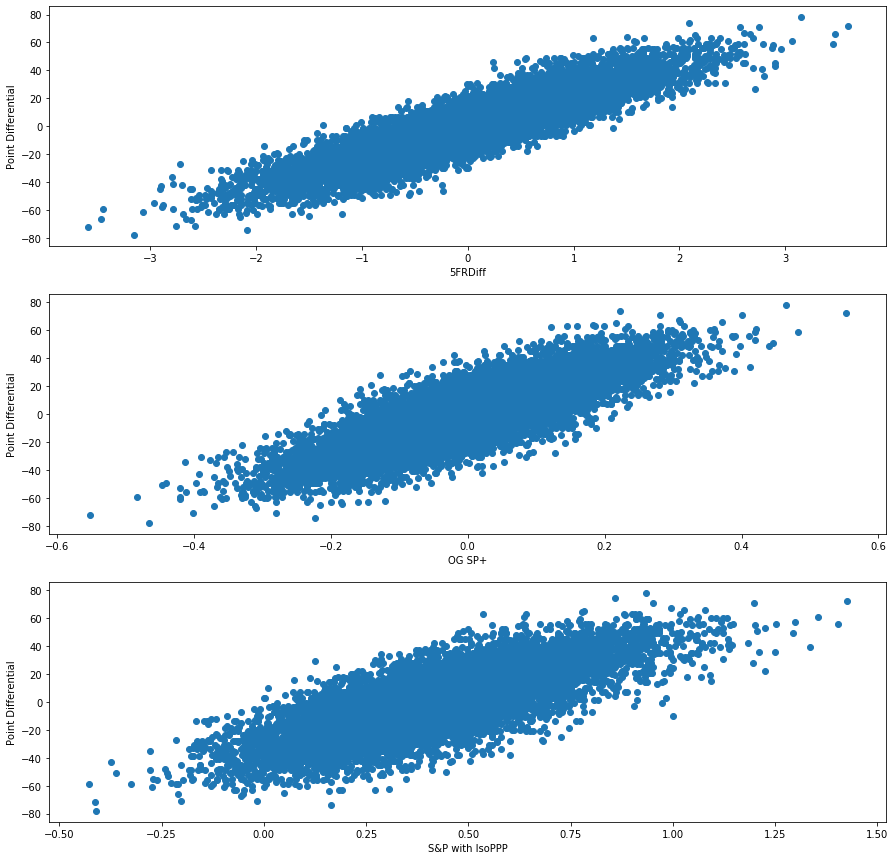

In [67]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [68]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912025,0.758809
S&PIsoPPPDiff,0.912025,1.000000,0.815979
PtsDiff,0.758809,0.815979,1.000000


In [69]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.04152,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.122680,-4.387538,-0.04152,-0.006633,0.012898,4.563898,-0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.42232,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.42232,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.26167,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553


In [70]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [71]:
# outliers

In [72]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.041520,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.422320,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.422320,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.261670,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553
6,UCLA,2012,322430242,49.0,25.0,0.361313,0.528571,0.128571,9.042857,0.824934,...,0,0.172590,9.625505,0.177623,0.013919,-0.013187,5.353201,0.701786,0.791273,1.135348


In [73]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [74]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 22.37568x + 0.10892
Mean Pred Score: -0.23057916241394752
Pred Std Dev: 19.4924344204201
Mean Abs Error: 7.504876630169436
Mdn Abs Error: 6.213468370817669
R-squared: 0.8068845710484139



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.765569,0.557559,0.499211,0.800073,0.594367,0.607532,0.981699,0.502474,0.771370,-0.459404,-0.446182,0.720732,0.738727,0.243489,0.538227,0.890235,0.898619,0.898619
OffSRDiff,0.765569,1.000000,0.491996,0.281631,0.693881,0.386193,0.436978,0.764223,0.724679,0.719380,-0.300176,-0.171736,0.654525,0.755945,-0.024053,0.529277,0.851544,0.886063,0.886063
OffERDiff,0.557559,0.491996,1.000000,0.154239,0.498349,0.277212,0.291598,0.541448,0.348818,0.806767,-0.212743,-0.086077,0.762074,0.620718,0.577224,0.189880,0.477786,0.499287,0.499287
FPDiff,0.499211,0.281631,0.154239,1.000000,0.611160,0.132450,0.122831,0.473851,0.047336,0.229700,-0.280585,-0.372200,0.217309,0.213922,0.026630,0.253049,0.590883,0.585216,0.585216
OppRateDiff,0.800073,0.693881,0.498349,0.611160,1.000000,0.208109,0.217892,0.800916,0.257230,0.667013,-0.322671,-0.298973,0.596066,0.735055,0.154256,0.504720,0.799842,0.817014,0.817014
OppEffDiff,0.594367,0.386193,0.277212,0.132450,0.208109,1.000000,0.753626,0.588764,0.498110,0.431722,-0.299237,-0.332829,0.404533,0.340567,0.182575,0.313534,0.502480,0.498431,0.498431
OppPPDDiff,0.607532,0.436978,0.291598,0.122831,0.217892,0.753626,1.000000,0.613431,0.556723,0.463564,-0.325810,-0.323539,0.447610,0.359124,0.189524,0.364848,0.564489,0.565574,0.565574
PPDDiff,0.981699,0.764223,0.541448,0.473851,0.800916,0.588764,0.613431,1.000000,0.500518,0.758265,-0.446211,-0.440138,0.706927,0.716442,0.229252,0.544912,0.883954,0.892124,0.892124
OppSRDiff,0.502474,0.724679,0.348818,0.047336,0.257230,0.498110,0.556723,0.500518,1.000000,0.508740,-0.239687,-0.120271,0.482049,0.434336,-0.001750,0.338121,0.600555,0.625343,0.625343
YPPDiff,0.771370,0.719380,0.806767,0.229700,0.667013,0.431722,0.463564,0.758265,0.508740,1.000000,-0.338357,-0.197924,0.921127,0.797884,0.546941,0.444140,0.704769,0.729302,0.729302


In [75]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['LinearPredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,LinearPredPtsDiff
ActPtsDiff,1.000000,0.748231,0.765569,0.720732,0.903676,0.499211,0.305241,0.890235,0.898619,0.898619
ActPts,0.748231,1.000000,0.564934,0.545206,0.689282,0.379306,0.224453,0.666367,0.673104,0.673104
Eff,0.765569,0.564934,1.000000,0.654525,0.794635,0.281631,0.061225,0.851544,0.886063,0.886063
Expl,0.720732,0.545206,0.654525,1.000000,0.692287,0.217309,0.074694,0.657563,0.679648,0.679648
FinDrv,0.903676,0.689282,0.794635,0.692287,1.000000,0.443418,0.243431,0.900665,0.916601,0.916601
FldPos,0.499211,0.379306,0.281631,0.217309,0.443418,1.000000,0.301448,0.590883,0.585216,0.585216
Trnovr,0.305241,0.224453,0.061225,0.074694,0.243431,0.301448,1.000000,0.474230,0.385448,0.385448
5FR,0.890235,0.666367,0.851544,0.657563,0.900665,0.590883,0.474230,1.000000,0.995147,0.995147
5FRDiff,0.898619,0.673104,0.886063,0.679648,0.916601,0.585216,0.385448,0.995147,1.000000,1.000000
LinearPredPtsDiff,0.898619,0.673104,0.886063,0.679648,0.916601,0.585216,0.385448,0.995147,1.000000,1.000000


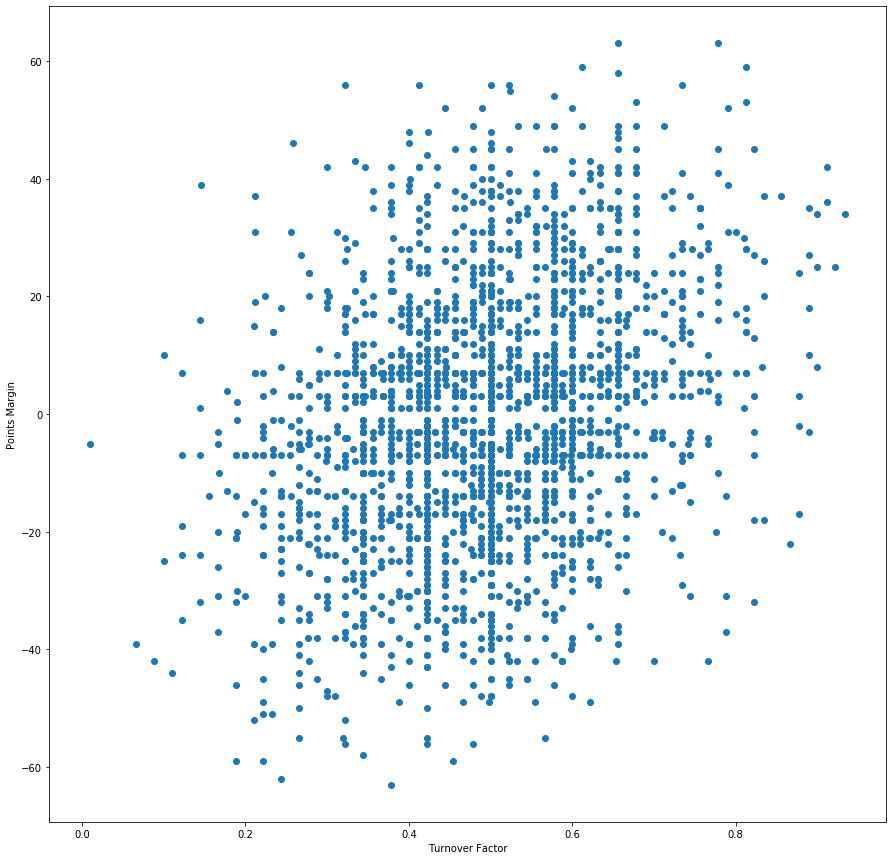

In [76]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

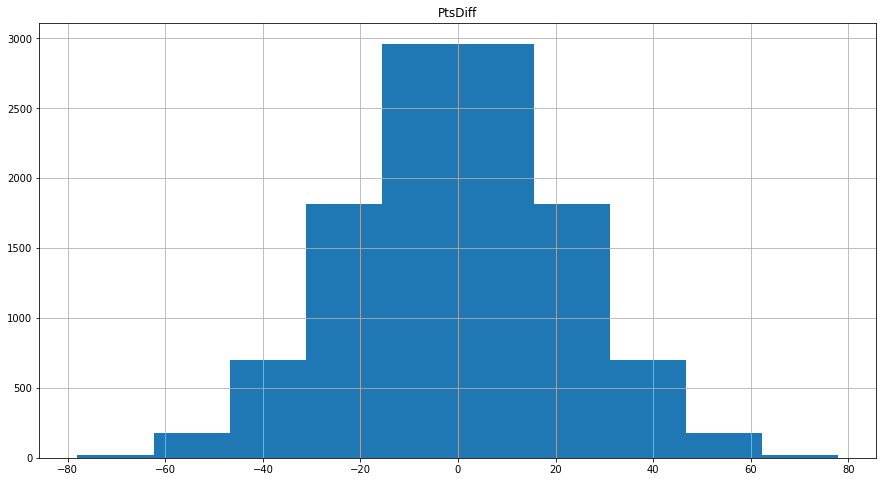

In [77]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

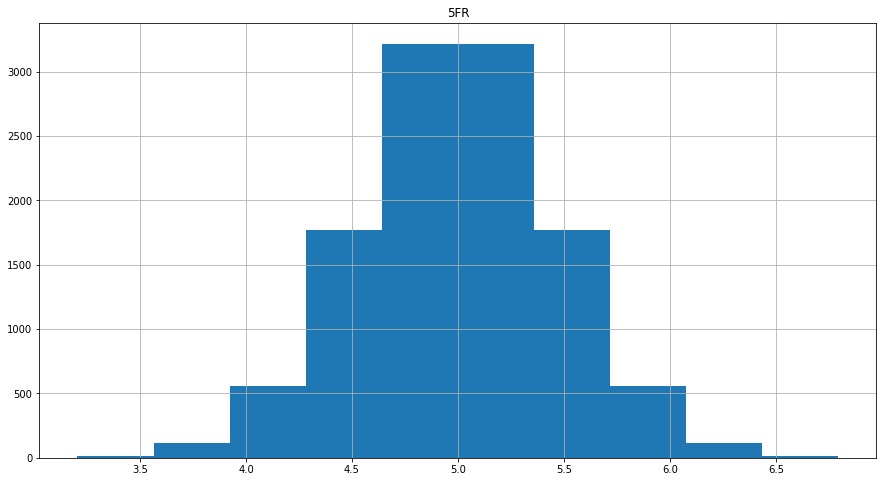

In [78]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

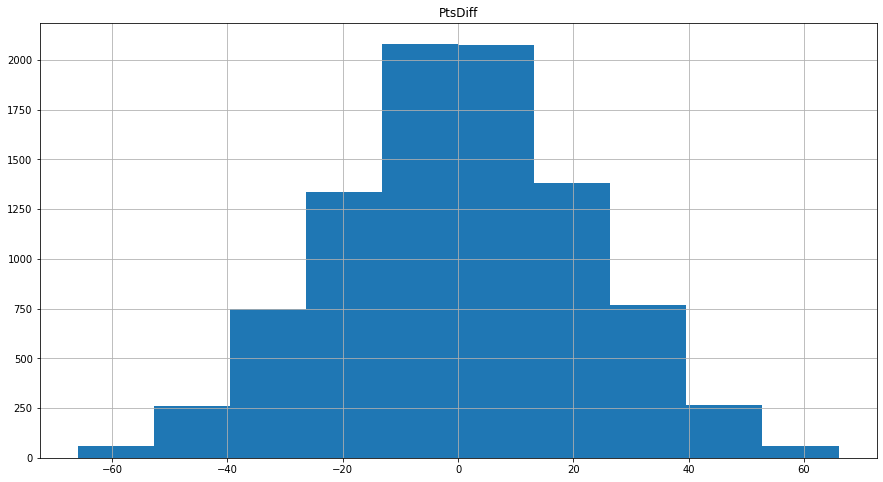

In [79]:
train_data.hist(column='PtsDiff', figsize=(15,8));

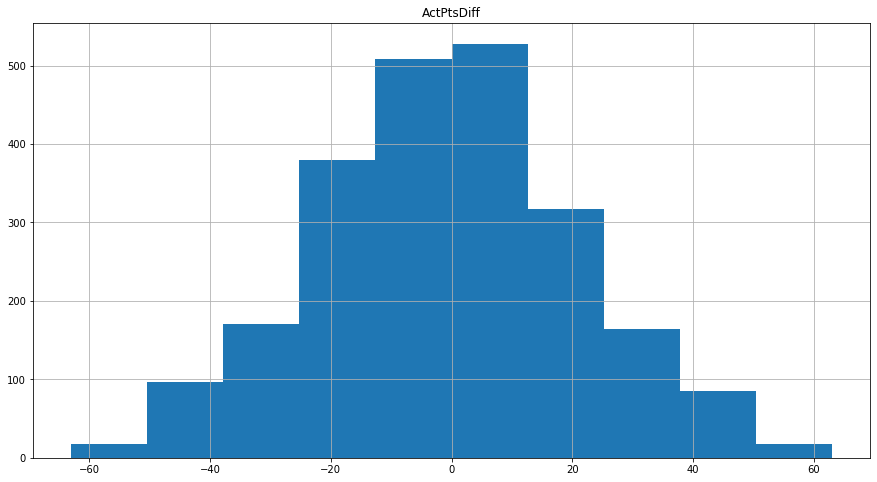

In [80]:
test.hist(column='ActPtsDiff', figsize=(15,8));

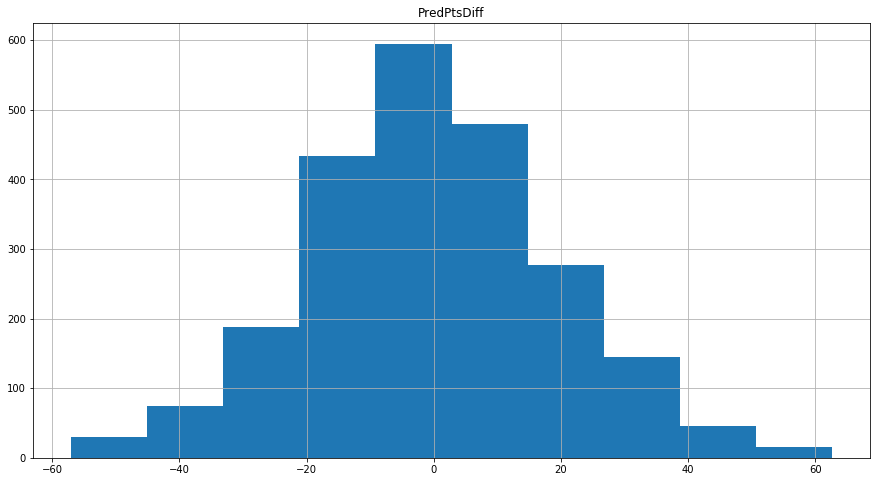

In [81]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [82]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [83]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4.0 (exact value: -4.493190622264797)
Z score: -0.21868030272223854
Win Prob for Virginia Tech: 41.34%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [84]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -16.0 (exact value: -16.428968983097775)
Z score: -0.8310090710739825
Win Prob for Georgia Tech: 20.30%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.630449,-0.739101
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.369551,0.739101


In [85]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -7.0 (exact value: -6.6069803965124)
Z score: -0.32712185130753046
Win Prob for Georgia Tech: 37.18%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.150071,0.300143
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.849929,-0.300143


In [86]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 6.0 (exact value: 6.002660439919407)
Z score: 0.3197773796690817
Win Prob for Mississippi State: 62.54%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.8683,-0.263399
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.1317,0.263399


In [87]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -8.0 (exact value: -8.251648759436712)
Z score: -0.4114965542025866
Win Prob for Texas A&M: 34.04%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.186823,0.373645
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.813177,-0.373645


In [88]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.944158,13,12.0,1.0
2,Clemson,0.937700,13,12.0,1.0
3,Alabama,0.921480,12,11.0,1.0
4,LSU,0.915258,13,12.0,1.0
5,Wisconsin,0.864995,13,11.0,2.0
6,Utah,0.838602,13,11.0,2.0
7,Oregon,0.822293,13,11.0,2.0
8,Oklahoma,0.821064,13,11.0,2.0
9,Appalachian State,0.807740,13,11.0,2.0
10,Notre Dame,0.797847,12,10.0,2.0


In [89]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.460331,1.539669
21,Clemson,10.602401,2.397599
53,LSU,10.455011,2.544989
128,Wisconsin,9.483545,3.516455
2,Alabama,9.363124,2.636876
115,Utah,9.195011,3.804989
78,Oklahoma,8.944407,4.055593
3,Appalachian State,8.897026,4.102974
82,Oregon,8.790995,4.209005
56,Memphis,8.589745,4.410255


In [90]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.606624,1
1,Florida State,2012,5.456845,2
2,Fresno State,2012,5.371180,3
3,Arizona State,2012,5.339381,4
4,Oklahoma,2012,5.339329,5
5,Notre Dame,2012,5.326277,6
6,Georgia,2012,5.306892,7
7,BYU,2012,5.306499,8
8,Kansas State,2012,5.302395,9
9,Ohio State,2012,5.285753,10


In [91]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    team_games = stored_game_boxes[stored_game_boxes.Team == team].GameID.to_list()
    for idx, item in enumerate(team_games, start=1):
        box = stored_game_boxes[stored_game_boxes.GameID == item]
        opp = filter_opponents(box, team)
        opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323080349.0,Army,2012.0,Air Force,8.0
8,323150021.0,San Diego State,2012.0,Air Force,9.0
9,323212005.0,Hawai'i,2012.0,Air Force,10.0


In [92]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
        
#     print(grouped_by_year.get_group((team1, year))[:1].tail(4))
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.1370442823413215, -21.549366255671984]

In [93]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 ML / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 ML / 6-6 ATS ------ 
#     ['North Carolina','Temple',5], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5], # MichSt 27, Wake 21
    ['Texas A&M', 'Oklahoma State', 7],
    ['Iowa', 'USC', 2.5],
    ['Air Force', 'Washington State', 3],
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Notre Dame', 'Iowa State', 4],
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Western Kentucky', 'Western Michigan', 3.5],
    ['Mississippi State', 'Louisville', 4],
    ['California', 'Illinois', 6.5],
    ['Florida','Virginia',14], # Orange Bowl
    ['Virginia Tech', 'Kentucky', 3],
    ['Arizona State', 'Florida State', 4],
    ['Navy', 'Kansas State', 2],
    ['Wyoming', 'Georgia State', 7],
    ['Utah', 'Texas', 7],
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    ['Ohio', 'Nevada', 7.5],
    ['Tulane', 'Southern Mississippi', 7],
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Michigan State,Wake Forest,3.5,14.778717,0.779352,True,Michigan State,Michigan State
0,Texas A&M,Oklahoma State,7.0,1.422649,0.533795,False,Texas A&M,Oklahoma State
0,Iowa,USC,2.5,3.569071,0.577276,True,Iowa,Iowa
0,Air Force,Washington State,3.0,2.330243,0.552261,False,Air Force,Washington State
0,Penn State,Memphis,7.0,-0.111599,0.502435,False,Memphis,Memphis
0,Notre Dame,Iowa State,4.0,8.542419,0.673671,True,Notre Dame,Notre Dame
0,LSU,Oklahoma,11.0,10.646864,0.711589,False,LSU,Oklahoma
0,Clemson,Ohio State,2.5,7.000338,0.644666,True,Clemson,Clemson
0,Western Kentucky,Western Michigan,3.5,7.211111,0.648685,True,Western Kentucky,Western Kentucky
0,Mississippi State,Louisville,4.0,2.458969,0.554872,False,Mississippi State,Louisville


In [94]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 7.0 (exact value: 6.611599761166277)
Z score: 0.3510171575292011
Win Prob for Virginia: 63.72%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.854693,-0.290614
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,5.145307,0.290614


In [95]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 13.0 (exact value: 12.643079524889313)
Z score: 0.6604438629695699
Win Prob for North Carolina: 74.55%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,5.280084,0.560169
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.719916,-0.560169


In [96]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 15.0 (exact value: 15.218080531837005)
Z score: 0.792546449614681
Win Prob for Pittsburgh: 78.60%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.337625,0.675249
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.662375,-0.675249


In [97]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -8.0 (exact value: -8.083492358313181)
Z score: -0.4028698020229116
Win Prob for Auburn: 34.35%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,5.183065,0.36613
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.816935,-0.36613


In [98]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 27.0 (exact value: 27.310898112490936)
Z score: 1.4129316370074676
Win Prob for Georgia: 92.12%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.607847,1.215694
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.392153,-1.215694


In [99]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 21.0 (exact value: 20.55981044898242)
Z score: 1.0665876392338425
Win Prob for Clemson: 85.69%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 5.0 (exact value: 4.781603025715021)
Z score: 0.2571347467445242
Win Prob for Georgia Tech: 60.15%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -13.0 (exact value: -13.483120495610763)
Z score: -0.6798812835462753
Win Prob for The Citadel: 24.83%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 27.0 (exact value: 27.033066346789287)
Z score: 1.3986783241728946
Win Prob for Temple: 91.90%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 13.0 (exact value: 12.643079524889313)
Z score: 0.6604438629695

,GameID,Year,Team,Opponent,PredWinProb,PredMOV,ActualMOV,PostGameWinProb
0,401111653,2019,Georgia Tech,Clemson,18.836468,-16.999536,-38.0,14.307904
1,401112441,2019,Georgia Tech,South Florida,81.747336,17.425242,4.0,60.146262
2,401112452,2019,Georgia Tech,The Citadel,97.804534,39.045808,-3.0,75.171018
3,401112469,2019,Georgia Tech,Temple,45.034854,-2.201702,-22.0,8.095473
4,401112475,2019,Georgia Tech,North Carolina,51.844900,0.671166,-16.0,25.448452
5,401112480,2019,Georgia Tech,Duke,23.113109,-14.098835,-18.0,25.901451
6,401112488,2019,Georgia Tech,Miami,36.367655,-6.565432,7.0,20.298425
7,401112498,2019,Georgia Tech,Pittsburgh,37.925399,-6.223346,-10.0,21.402106
8,401112504,2019,Georgia Tech,Virginia,33.454154,-8.100619,-5.0,18.170691
9,401112511,2019,Georgia Tech,Virginia Tech,13.263919,-21.945188,-45.0,0.082132


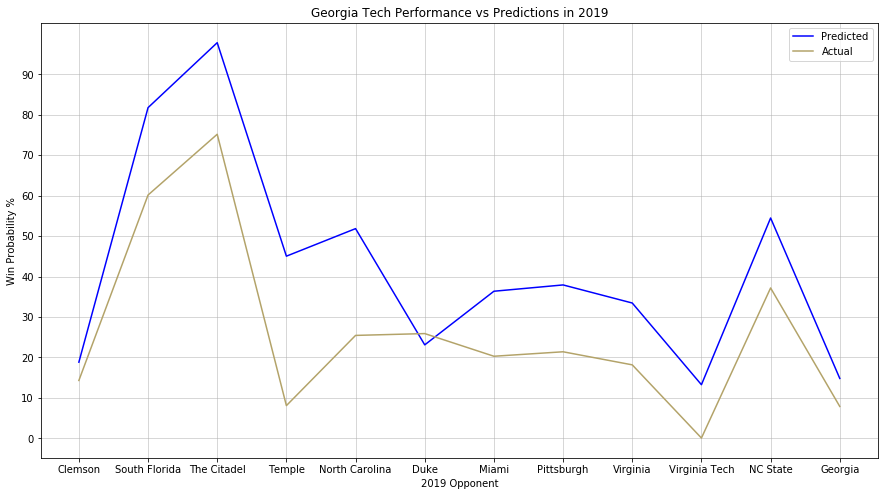

In [100]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

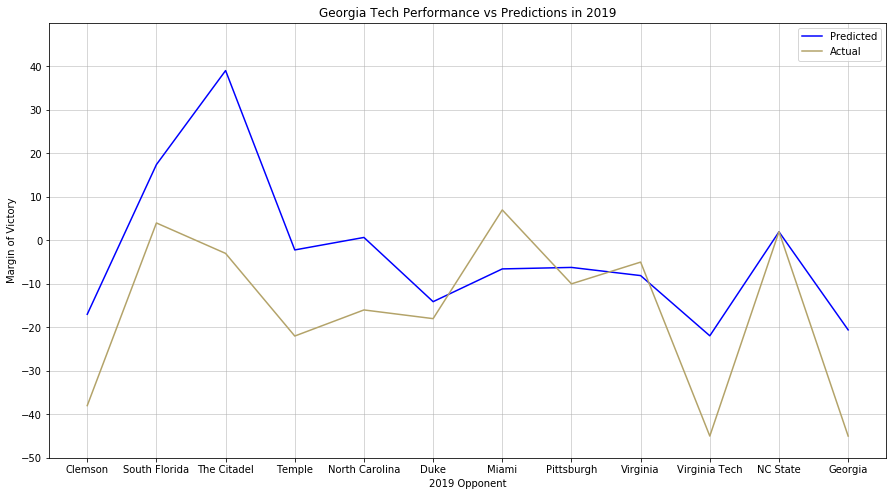

In [101]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 37.0 (exact value: 36.50628534516909)
Z score: 1.8846729821031398
Win Prob for Georgia Tech: 97.03%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 14.0 (exact value: 13.520139406414735)
Z score: 0.7054387498374012
Win Prob for South Florida: 75.97%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 11.0 (exact value: 11.122412483308185)
Z score: 0.5824306703234995
Win Prob for Pittsburgh: 71.99%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 31.0 (exact value: 30.663485752013)
Z score: 1.5849259383457306
Win Prob for Clemson: 94.35%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 40.0 (exact value: 39.88964671878436)
Z scor

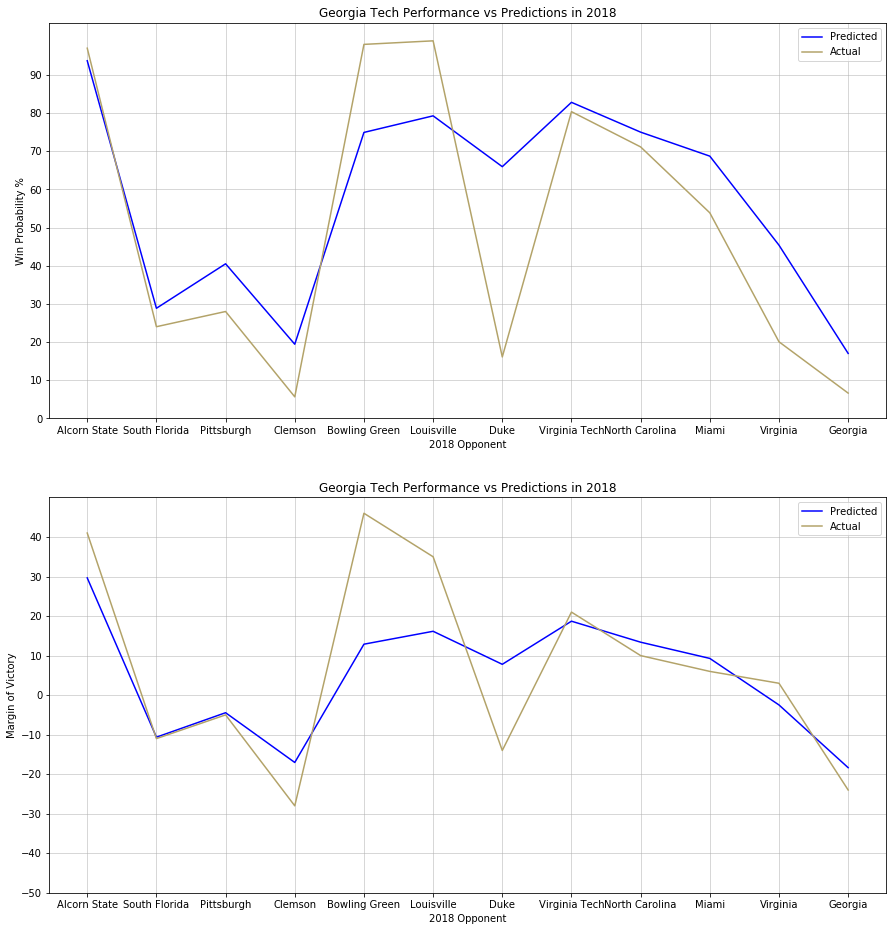

In [102]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

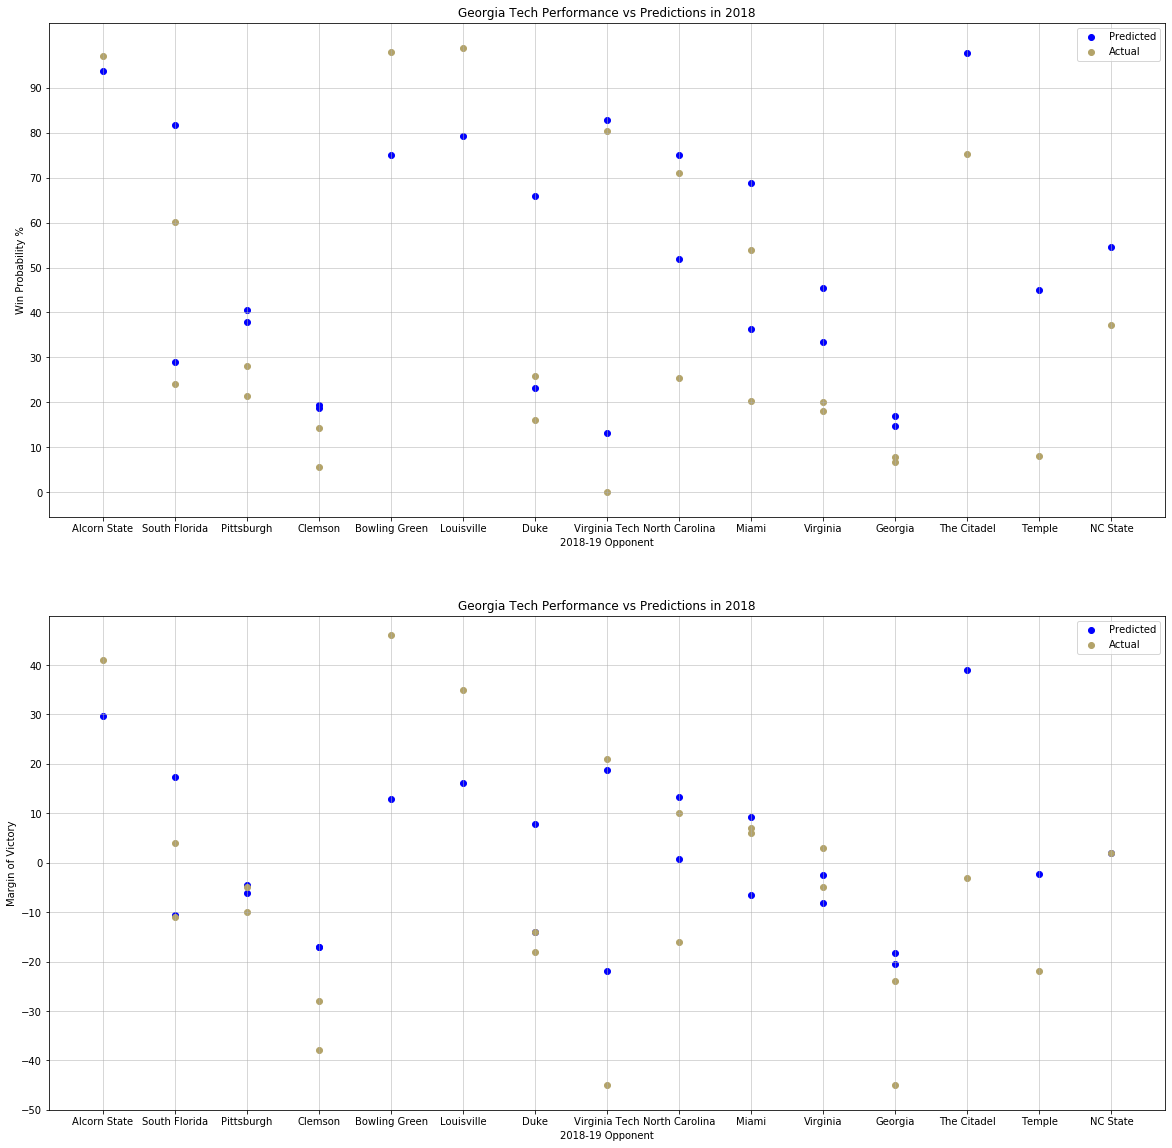

In [103]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [104]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.581310,0.523315,0.435028,0.365191,0.286904,0.285329,0.383764
2013,0.581310,1.000000,0.555835,0.369550,0.250899,0.232639,0.179753,0.281026
2014,0.523315,0.555835,1.000000,0.559955,0.460823,0.287926,0.281157,0.359910
2015,0.435028,0.369550,0.559955,1.000000,0.642715,0.446838,0.345127,0.368099
2016,0.365191,0.250899,0.460823,0.642715,1.000000,0.567064,0.409997,0.581482
2017,0.286904,0.232639,0.287926,0.446838,0.567064,1.000000,0.602075,0.539130
2018,0.285329,0.179753,0.281157,0.345127,0.409997,0.602075,1.000000,0.583893
2019,0.383764,0.281026,0.359910,0.368099,0.581482,0.539130,0.583893,1.000000


In [105]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,North Carolina,UCF,Away,40.533282,-4.900331
1,2020,North Carolina,Auburn,Home,33.283327,-8.653319
2,2020,North Carolina,James Madison,Home,98.246231,40.849474
3,2020,North Carolina,Connecticut,Home,77.307443,14.369450
4,2020,North Carolina,Boston College,Away,49.417017,-0.515436
5,2020,North Carolina,Duke,Away,52.106163,0.798977
6,2020,North Carolina,Miami,Away,38.292864,-6.035389
7,2020,North Carolina,Georgia Tech,Home,64.173249,6.846998
8,2020,North Carolina,NC State,Home,59.950058,4.682579
9,2020,North Carolina,Pittsburgh,Home,52.549058,1.015747


In [106]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)